# Méthode de détection

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

from clib.flow import *
from clib.bellhop import *
import subprocess
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

### Profils de Méditerrannée

In [2]:
s = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='profiles')

In [3]:
c_med = s.SSP['mediterrannee']['c'][:,::10]
depth_med = s.SSP['mediterrannee']['depth'][::10]

### Profils Gulf Stream

In [4]:
g1 = bellhop({'gs': {'datadir': '/home/datawork-lops-osi/jgula/NESED/', 'lon': -61.2, \
                    'lat': 42., 'plot_map': False, 'contour':False}}, zmax = 4900)

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
Uses the following output file: /home/datawork-lops-osi/jgula/NESED/nesed_avg.00060.nc


In [5]:
g2 = bellhop({'gs': {'datadir': '/home/datawork-lops-osi/jgula/NESED/', 'lon': -66.6, \
                    'lat': 36., 'plot_map': False, 'contour': False}}, zmax = 4900)

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
Uses the following output file: /home/datawork-lops-osi/jgula/NESED/nesed_avg.00060.nc


In [6]:
c_gs = np.vstack((g1.SSP['gs']['c'], g2.SSP['gs']['c']))
depth_gs = np.vstack((g1.SSP['gs']['depth'], g2.SSP['gs']['depth']))

---
---
## Exemple du travail à faire sur un 1er profil

aaaa


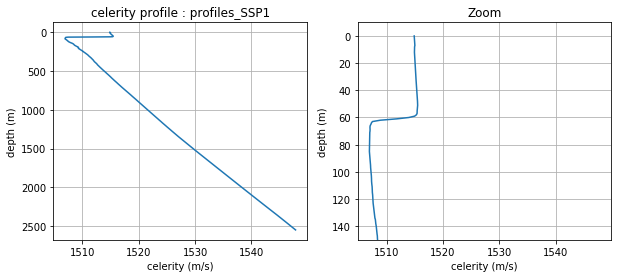

In [17]:
issp=0
s.plotssp('mediterrannee', Issp=issp)
plt.savefig('profile_med1', dpi=100)

In [7]:
### Creat .env file

issp=0                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]
s.params['NDepth'] = 6
s.params['NRange'] = 11
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1.env' )


In [7]:
### read file .arr 
Arr1, Pos1 = s.read_arrivals_asc ('files/med1.arr', Narrmx = 2785)

Max.number of arrivals for source index 0 is 2783


In [8]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos1['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos1['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


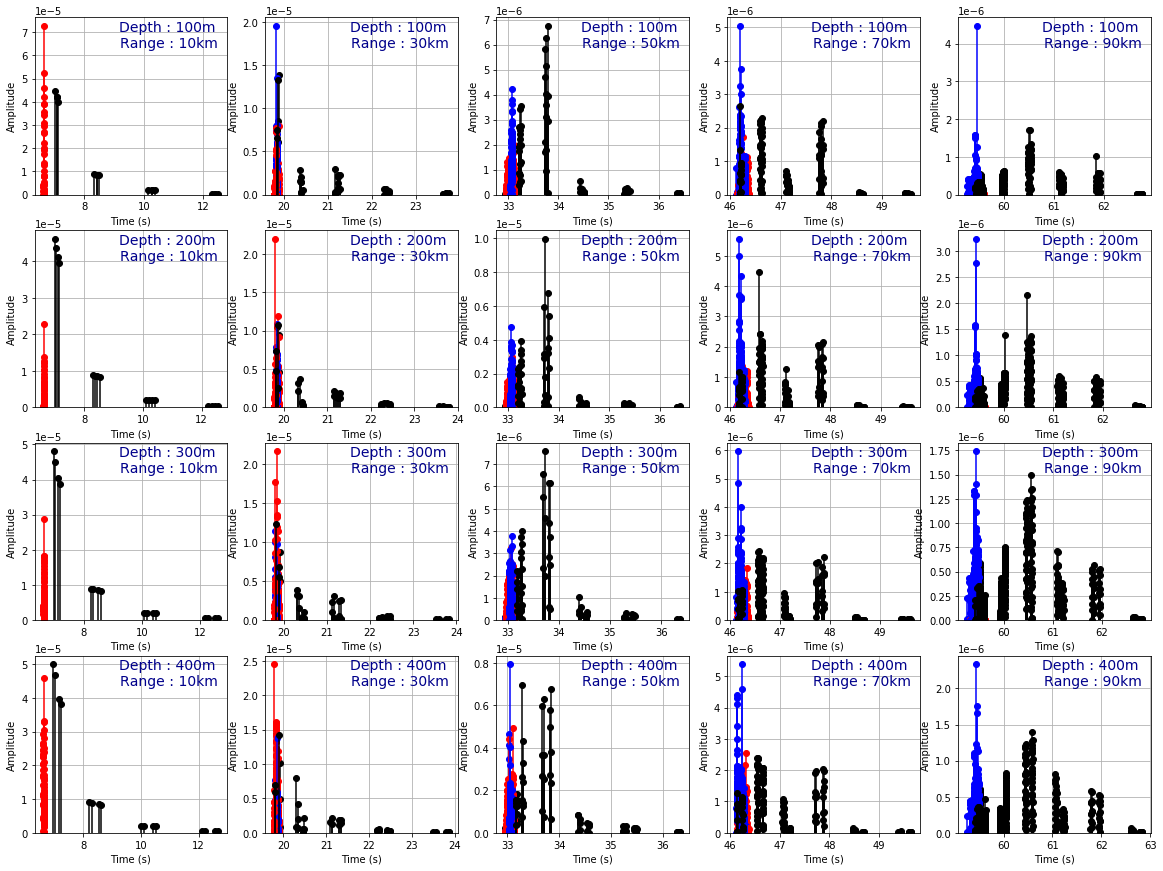

In [10]:
isd = 0       # choice of source depth

Total_time = []
Amp_min = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        s.plotarr(Arr1, Pos1, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr1['Narr'][irr,ird,isd])
        amp = Arr1['A'][irr,:Narr, ird, isd]
        Amp_min.append(np.min(abs(amp)))
        times = Arr1['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))

plt.savefig('vignettes_med1', dpi=100)

### ZOOM 

In [19]:
# sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

# SL - TL - NL + DI + PG  >  RL 

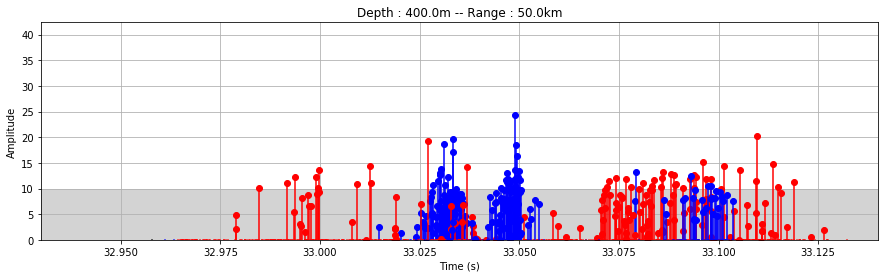

In [19]:
ird = 4       # depth : 300m    
irr = 5       # range : 50km  

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
Narr = int(Arr1['Narr'][irr, ird, isd])
for i in range (Narr) : 
    t = Arr1['delay'][irr, i, ird, isd]
    TL = -20*np.log10 (abs(Arr1['A'][irr, i, ird, isd]))
    RL = SL - TL -NL +DI + PG
    markerline, stemlines, baseline = plt.stem( [t], [RL])            

    if np.logical_and ( Arr1['NumTopBnc'][irr, i,ird,isd] == 0, Arr1['NumBotBnc'][irr, i,ird,isd] == 0):
        plt.setp(stemlines, color = 'r')
        plt.setp(markerline, color = 'r')

    elif Arr1['NumBotBnc'][irr, i,ird,isd] == 0:
        plt.setp(stemlines, color = 'b')
        plt.setp(markerline, color = 'b')

    else : 
        plt.setp(stemlines, color = 'k')
        plt.setp(markerline, color = 'k')

plt.ylim(ymin=0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Source depth : %.1fm -- Receiver depth : %.1fm -- Receiver range : %.1fkm' \
#          % (Pos['s']['depth'][isd], Pos['r']['depth'][ird], Pos['r']['range'][irr]/1000.))
plt.title('Depth : %.1fm -- Range : %.1fkm' %(Pos1['r']['depth'][ird], Pos1['r']['range'][irr]/1000.))
plt.grid()
plt.xlim([32.93, 33.14])
#plt.xlim([33.025, 33.08])

ax.fill_between(np.array([0.,75.]), np.array([10., 10.]), facecolor='lightgrey')

---
## CHOIX de la méthode de détection : 1er rayon > 10 dB

In [185]:
isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr1['Narr'][irr,ird,isd])
        amp = Arr1['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr1['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        t_first = np.min(t_ok)
        idx_first = np.where(times==t_first)[0][0]
        
        # Chosen ray features
        NumTopBnc_f = Arr1['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
        NumBotBnc_f = Arr1['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
        SrcAngle_f  = Arr1['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
        # Appends
        TopBnc.append(NumTopBnc_f)
        BotBnc.append(NumBotBnc_f)
        SrcAngle.append(SrcAngle_f)
        Tarr.append(t_first)

In [186]:
n = R.size
print('SrcAngle : \n')
print ('                  10km          30km         50km         70km         90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :  %.5f°    %.5f°    %.5f°    %.5f°    %.5f°' %(D[i], SrcAngle[n*i], \
                                                                        SrcAngle[n*i+1], SrcAngle[n*i+2], \
                                                                        SrcAngle[n*i+3], SrcAngle[n*i+4]))

SrcAngle : 

                  10km          30km         50km         70km         90km

  Depth = 100m :  2.34520°    0.60505°    -6.07551°    -10.11584°    -8.04567°
  Depth = 200m :  2.03517°    -0.88507°    -1.80515°    -10.20585°    -8.03567°
  Depth = 300m :  0.48504°    -0.73506°    0.88507°    -10.19585°    8.41570°
  Depth = 400m :  -1.33511°    -0.73506°    -0.99508°    10.84590°    8.70573°


In [187]:
k = True
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k = False
print ('Pas de réfélchis fond : %s.' %k)

Pas de réfélchis fond : True.


In [188]:
n = R.size
print('Nombre de rebonds sur la surface : \n')
print ('                 10km     30km     50km     70km     90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d        %d        %d        %d        %d' %(D[i], TopBnc[n*i], \
                                                                        TopBnc[n*i+1], TopBnc[n*i+2], \
                                                                        TopBnc[n*i+3], TopBnc[n*i+4]))

Nombre de rebonds sur la surface : 

                 10km     30km     50km     70km     90km

  Depth = 100m :   0        0        2        2        3
  Depth = 200m :   0        0        0        2        3
  Depth = 300m :   0        0        0        2        2
  Depth = 400m :   0        0        0        1        2


In [189]:
#ird = 2   # *100 = depth (m)
#irr = 9   # *10 = range (km)

Dist = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        

        # angle surlequel on travaille

        idx_d = np.where(D==ird*100.)[0][0]
        idx_r = np.where(R==irr*10.*1000.)[0][0]
        angle = SrcAngle[R.size*idx_d + idx_r]

        ### Creat .env file E

        issp=0                          # sound speed profile number
        s.params['file_type'] = 'E'
        s.params['ALimites'] = [angle]

        s.params['zmin'] = Pos1['r']['depth'][ird]          # receiver depth (m)
        s.params['rmin'] = Pos1['r']['range'][irr]/1000.    # receiver range (km)  

        s.params['NDepth'] = 1
        s.params['NRange'] = 1
        s.params['NBeams'] = 2

        s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1_E.env' )
        
        ### execute bellhop
        subprocess.call(["bellhop.exe", 'med1_E'])
        
        ### output .ray file
        dictE = s.plotE ('med1_E.ray', plot = False)
        angles_E = dictE['SrcAngle']
        

        ### distance correspondante  
        if angles_E.size == 1 : 
            dist = dictE['Dist'][0]
        else :
            dist = dictE['Dist'][np.where(angles_E !=0.)][0]
        
        Dist.append(dist)


In [190]:
n = R.size
print('Distance : \n')
print ('                   10km      30km       50km      70km      90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d     %d      %d     %d     %d' %(D[i], Dist[n*i], \
                                                                        Dist[n*i+1], Dist[n*i+2], \
                                                                        Dist[n*i+3], Dist[n*i+4]))

Distance : 

                   10km      30km       50km      70km      90km

  Depth = 100m :   10009     30044      50112     70407     90357
  Depth = 200m :   10011     30042      50057     70419     90354
  Depth = 300m :   10014     30046      50072     70412     90347
  Depth = 400m :   10010     30046      50068     70436     90366


---
## Régressions linéaires

In [191]:
### On connaît le temps d'arrivée et le range correspondant pour les 20 vignettes
TT = np.array(Tarr)
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [192]:
### 1 seule régression linéaire 
res = np.polyfit(TT, REAL_RANGE,1)
Rreg = res[0] * TT + res[1]
Diff1 = REAL_RANGE - Rreg

In [193]:
### autre méthode, qui nous donne le coef de détermination r²
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(TT, REAL_RANGE)

#To get coefficient of determination (r_squared)
print("r-squared:", r_value**2)

r-squared: 0.9999981869875505


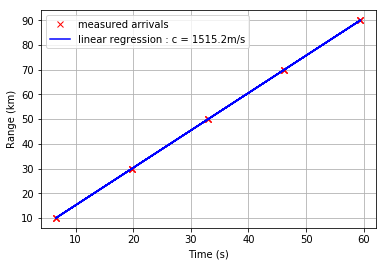

In [194]:
plt.figure()
plt.plot(TT, REAL_RANGE/1000., 'xr', label = 'measured arrivals')
plt.plot(TT, Rreg/1000., 'b', label = 'linear regression : c = %.1fm/s' %res[0])
plt.xlabel('Time (s)')
plt.ylabel('Range (km)')
plt.grid()
plt.legend()
plt.savefig('reg_lin1_med1', dpi = 100)

In [83]:
### 2 régressions linéaires correspondant aux deux catégories de rayons (avant et après 60km)
idx1 = np.where(REAL_RANGE <= 50.*1000.)[0]
idx2 = np.where(REAL_RANGE >= 50.*1000.)[0]

res1 = np.polyfit(TT[idx1], REAL_RANGE[idx1],1)
res2 = np.polyfit(TT[idx2], REAL_RANGE[idx2],1)

Rreg_inf60 = res1[0] * TT[idx1] + res1[1]
Rreg_sup60 = res2[0] * TT[idx2] + res2[1]

diff_a = REAL_RANGE[idx1] - Rreg_inf60
diff_b = REAL_RANGE[idx2] - Rreg_sup60
Diff2 = np.hstack( (diff_a, diff_b) )

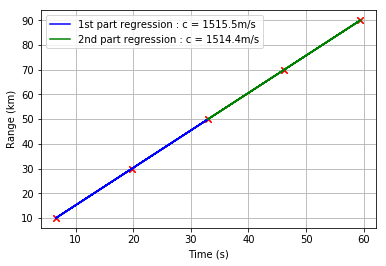

In [87]:
plt.figure()
plt.plot(TT, REAL_RANGE/1000., 'xr')
plt.plot(TT[idx1], Rreg_inf60/1000., 'b', label = '1st part regression : c = %.1fm/s' %res1[0])
plt.plot(TT[idx2], Rreg_sup60/1000., 'g', label = '2nd part regression : c = %.1fm/s' %res2[0])
plt.xlabel('Time (s)')
plt.ylabel('Range (km)')
plt.grid()
plt.legend()

#plt.savefig('reg_lin1_med1', dpi = 100)

In [88]:
### Mean values 
print(np.mean(abs(Diff1)))
print(np.mean(abs(Diff2)))

33.1029759819191
31.304746184374306


In [89]:
### Max values 
print(np.max(abs(Diff1)))
print(np.max(abs(Diff2)))

76.36858010820288
85.18482261207828


In [24]:
### Faire tableau avec les stats ... (min, max, mean, e_t, ...)

# Vérifications et stats avec plus de vignettes (19 x 9) ...

In [195]:
### Creat .env file

issp=0                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 11
s.params['NRange'] = 21
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1_complete.env' )

In [44]:
### read file .arr 
Arr2, Pos2 = s.read_arrivals_asc ('files/med1_complete.arr', Narrmx = 2786)

Max.number of arrivals for source index 0 is 2783


In [90]:
### Reponses impulsionnelles
D = np.arange(50., 450.+1., 50.)         # tous les 50m
R = np.arange(5., 95.+1., 5.)* 1000.     # tous les 5km
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  171


In [91]:
# 1er rayon supérieur à 10dB

isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr2['Narr'][irr,ird,isd])
        amp = Arr2['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr2['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        if len(t_ok) != 0 : 
            t_first = np.min(t_ok)
        
            idx_first = np.where(times==t_first)[0][0]
        
            # Chosen ray features
            NumTopBnc_f = Arr2['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
            NumBotBnc_f = Arr2['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
            SrcAngle_f  = Arr2['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
            # Appends
            TopBnc.append(NumTopBnc_f)
            BotBnc.append(NumBotBnc_f)
            SrcAngle.append(SrcAngle_f)
            Tarr.append(t_first)
            
        else : 
            TopBnc.append(np.NaN)
            BotBnc.append(np.NaN)
            SrcAngle.append(np.NaN)
            Tarr.append(np.NaN)
            

In [105]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
        print(i)
print ('Nombre de réfélchis fond : %d/%d.' %(k, len(BotBnc)))

53
72
91
139
Nombre de réfélchis fond : 4/171.


In [106]:
IRD.size

9

In [107]:
IRR.size

19

In [93]:
Dist = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        

        # angle surlequel on travaille

        idx_d = np.where(D==ird*50.)[0][0]
        idx_r = np.where(R==irr*5.*1000.)[0][0]
        angle = SrcAngle[R.size*idx_d + idx_r]

        ### Creat .env file E

        issp=0                          # sound speed profile number
        s.params['file_type'] = 'E'
        s.params['ALimites'] = [angle]

        s.params['zmin'] = Pos2['r']['depth'][ird]          # receiver depth (m)
        s.params['rmin'] = Pos2['r']['range'][irr]/1000.    # receiver range (km)  

        s.params['NDepth'] = 1
        s.params['NRange'] = 1
        s.params['NBeams'] = 2

        s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1_E.env' )
        
        ### execute bellhop
        subprocess.call(["bellhop.exe", 'med1_E'])
        
        ### output .ray file
        dictE = s.plotE ('med1_E.ray', plot = False)
        angles_E = dictE['SrcAngle']
        

        ### distance correspondante  
        if angles_E.size == 1 : 
            dist = dictE['Dist'][0]
        
        elif angles_E.size ==2 :
            dist = dictE['Dist'][np.where(angles_E !=0.)][0]
        
        else :
            dist = np.NaN
        
        Dist.append(dist)
        
Dist = np.array(Dist)

---
### Avec la régression linéaire précédente

In [94]:
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [95]:
### 2 régressions linéaires correspondant aux deux catégories de rayons (avant et après 60km)
Time = np.array(Tarr)

idx1tot = np.where(REAL_RANGE < 60.*1000.)[0]
idx2tot = np.where(REAL_RANGE >= 60.*1000.)[0]

Rtot_inf60 = res1[0] * Time[idx1tot] + res1[1]
Rtot_sup60 = res2[0] * Time[idx2tot] + res2[1]


diff_a = REAL_RANGE[idx1tot] - Rtot_inf60
diff_b = REAL_RANGE[idx2tot] - Rtot_sup60
Diff_tot = np.hstack( (diff_a, diff_b) )

In [96]:
res1[0]

1515.4804658572348

In [97]:
res2[0]

1514.3637069045265

In [98]:
res[0]

1515.2262881729666

In [99]:
np.max(abs(Diff_tot))

448.7768340757757

In [100]:
e_t = np.sqrt( np.mean( (Diff_tot)**2 ) )
e_t

69.42185055255433

---
### En une seule partie 

In [52]:
Rtot = res[0] * Time + res[1]
Diff_tot1 = REAL_RANGE - Rtot

In [108]:
np.min(abs(Diff_tot1))

0.9666701146343257

In [109]:
e_t = np.sqrt( np.mean( (Diff_tot1)**2 ) )
e_t

70.14404980188772

In [55]:
sort = sorted(abs(Diff_tot1))

In [112]:
np.min(sort[:-3])

0.9666701146343257

In [110]:
### on a 4 réfléchis fond qui introduisent de grandes erreurs
e_t = np.sqrt( np.mean( (np.array(sort[:-3]))**2 ) )
e_t

44.78204990100125

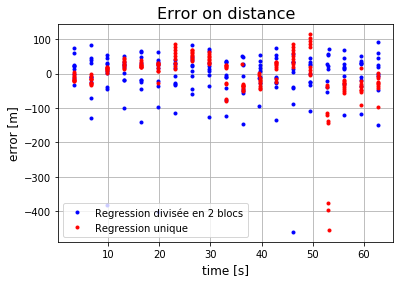

In [61]:
### error on range : real range - range from linear regression
plt.figure()
plt.plot(Time, Diff_tot, 'b.', label = 'Regression divisée en 2 blocs')
plt.plot(Time, Diff_tot1, 'r.', label = 'Regression unique')
plt.title('Error on distance',fontsize=16)
plt.xlabel('time [s]',fontsize=12)
plt.ylabel('error [m]',fontsize=12)
plt.grid()
plt.legend()

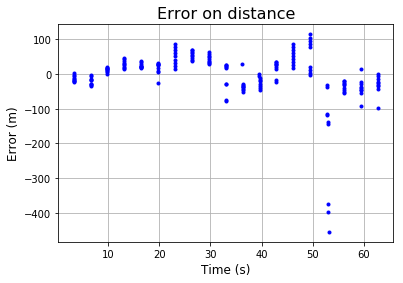

In [101]:
### error on range : real range - range from linear regression
plt.figure()
plt.plot(Time, Diff_tot1, 'b.')
plt.title('Error on distance',fontsize=16)
plt.xlabel('Time (s)',fontsize=12)
plt.ylabel('Error (m)',fontsize=12)
plt.grid()

plt.savefig('error_med1', dpi=100)

---
---
# Profil 2 

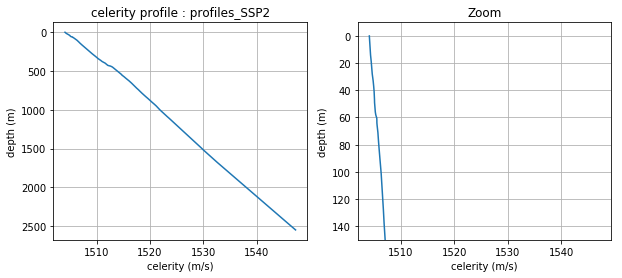

In [113]:
issp=1
s.plotssp('mediterrannee', Issp=issp)
plt.savefig('profile_med2', dpi=100)

In [31]:
### Creat .env file

issp=1                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 6
s.params['NRange'] = 11
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med2.env' )

In [114]:
### read file .arr 
Arr_prof2, Pos_prof2 = s.read_arrivals_asc ('files/med2.arr', Narrmx = 340)

Max.number of arrivals for source index 0 is 339


In [195]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_prof2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_prof2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


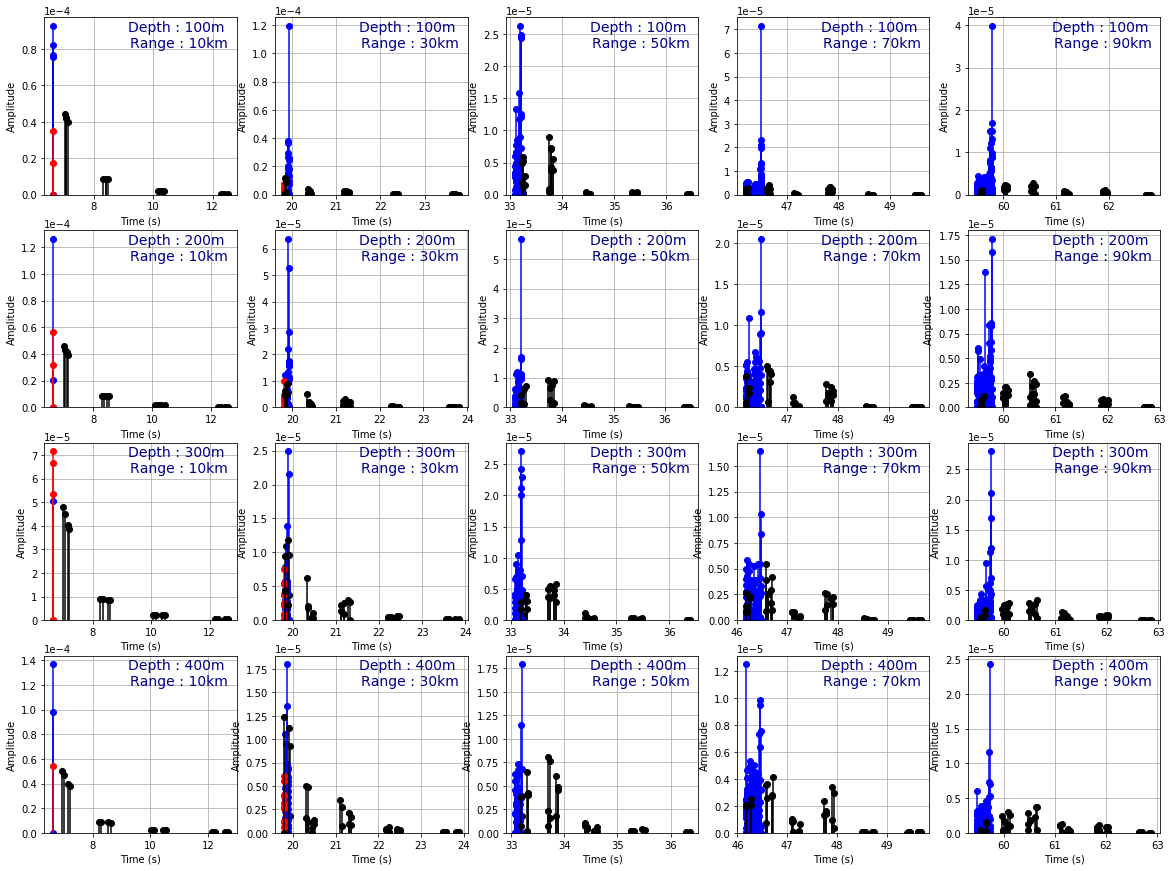

In [116]:
isd = 0       # choice of source depth

Total_time = []
Amp_min = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        s.plotarr(Arr_prof2, Pos_prof2, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr_prof2['Narr'][irr,ird,isd])
        amp = Arr_prof2['A'][irr,:Narr, ird, isd]
        Amp_min.append(np.min(abs(amp)))
        times = Arr_prof2['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))
        
plt.savefig('vignettes_med2', dpi=100)

### Zoom

In [117]:
# sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

# SL - TL - NL + DI + PG  >  RL 

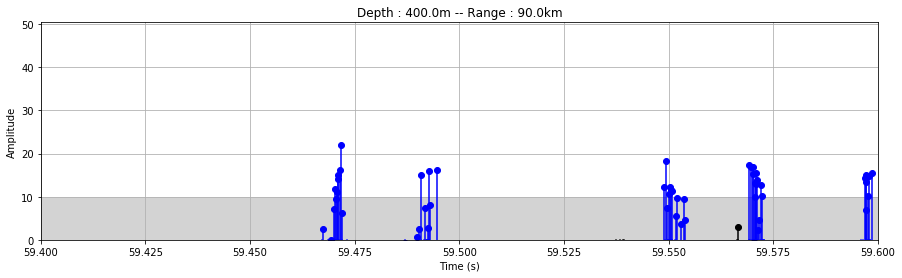

In [36]:
ird = 4       # depth : 300m    
irr = 9       # range : 50km  

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
Narr = int(Arr_prof2['Narr'][irr, ird, isd])
for i in range (Narr) : 
    t = Arr_prof2['delay'][irr, i, ird, isd]
    TL = -20*np.log10 (abs(Arr_prof2['A'][irr, i, ird, isd]))
    RL = SL - TL -NL +DI + PG
    markerline, stemlines, baseline = plt.stem( [t], [RL])            

    if np.logical_and ( Arr_prof2['NumTopBnc'][irr, i,ird,isd] == 0, Arr_prof2['NumBotBnc'][irr, i,ird,isd] == 0):
        plt.setp(stemlines, color = 'r')
        plt.setp(markerline, color = 'r')

    elif Arr_prof2['NumBotBnc'][irr, i,ird,isd] == 0:
        plt.setp(stemlines, color = 'b')
        plt.setp(markerline, color = 'b')

    else : 
        plt.setp(stemlines, color = 'k')
        plt.setp(markerline, color = 'k')

plt.ylim(ymin=0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Source depth : %.1fm -- Receiver depth : %.1fm -- Receiver range : %.1fkm' \
#          % (Pos['s']['depth'][isd], Pos['r']['depth'][ird], Pos['r']['range'][irr]/1000.))
plt.title('Depth : %.1fm -- Range : %.1fkm' %(Pos_prof2['r']['depth'][ird], Pos_prof2['r']['range'][irr]/1000.))
plt.grid()
#plt.xlim([6., 8.])
#plt.xlim([33., 33.9])
plt.xlim([59.4,59.6])

ax.fill_between(np.array([0.,75.]), np.array([10., 10.]), facecolor='lightgrey')

## CHOIX de la méthode de détection : 1er rayon > 10dB

In [318]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90., 100.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_prof2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_prof2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  24


In [319]:
isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr_prof2['Narr'][irr,ird,isd])
        amp = Arr_prof2['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr_prof2['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        t_first = np.min(t_ok)
        idx_first = np.where(times==t_first)[0][0]

        
        # Chosen ray features
        NumTopBnc_f = Arr_prof2['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
        NumBotBnc_f = Arr_prof2['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
        SrcAngle_f  = Arr_prof2['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
        # Appends
        TopBnc.append(NumTopBnc_f)
        BotBnc.append(NumBotBnc_f)
        SrcAngle.append(SrcAngle_f)
        Tarr.append(t_first)

In [320]:
k = True
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k = False
print ('Pas de réfélchis fond : %s.' %k)

Pas de réfélchis fond : True.


In [321]:
n = R.size
print('Nombre de rebonds sur la surface : \n')
print ('                 10km     30km     50km     70km     90km    100km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d        %d        %d        %d        %d       %d' %(D[i], TopBnc[n*i], \
                                                                        TopBnc[n*i+1], TopBnc[n*i+2], \
                                                                TopBnc[n*i+3], TopBnc[n*i+4], TopBnc[n*i+5]))

Nombre de rebonds sur la surface : 

                 10km     30km     50km     70km     90km    100km

  Depth = 100m :   0        0        1        1        2       2
  Depth = 200m :   0        0        1        1        2       2
  Depth = 300m :   0        0        1        1        2       2
  Depth = 400m :   0        0        1        1        2       2


In [322]:
### On connaît le temps d'arrivée et le range correspondant pour les 20 vignettes
TT = np.array(Tarr)
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [323]:
TT.size

24

In [324]:
### 1 seule régression linéaire 
res = np.polyfit(TT, REAL_RANGE,1)
Rreg = res[0] * TT + res[1]
Diff1 = REAL_RANGE - Rreg

In [325]:
### Mean values 
print(np.mean(abs(Diff1)))

48.42229179208349


In [326]:
e_t = np.sqrt( np.mean( (Diff1)**2 ) )
e_t

57.222648934398435

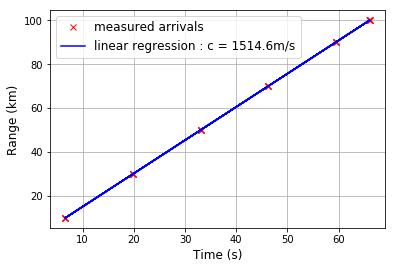

In [327]:
plt.figure()
plt.plot(TT, REAL_RANGE/1000., 'xr', label = 'measured arrivals')
plt.plot(TT, Rreg/1000., 'b', label = 'linear regression : c = %.1fm/s' %res[0])
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Range (km)', fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('reg_lin1_med2', dpi = 100)

In [328]:
### 3 régressions linéaires correspondant aux trois catégories de rayons

idx1 = np.where(REAL_RANGE < 40.*1000.)[0]
idx2 = np.where(np.logical_and(REAL_RANGE >= 40.*1000., REAL_RANGE < 80.*1000.) )[0]
idx3 = np.where(REAL_RANGE >= 80.*1000.)[0]

res1 = np.polyfit(TT[idx1], REAL_RANGE[idx1],1)
res2 = np.polyfit(TT[idx2], REAL_RANGE[idx2],1)
res3 = np.polyfit(TT[idx3], REAL_RANGE[idx3],1)

Rreg_inf40 = res1[0] * TT[idx1] + res1[1]
Rreg_inf80 = res2[0] * TT[idx2] + res2[1]
Rreg_sup80 = res3[0] * TT[idx3] + res3[1]


diff_a = REAL_RANGE[idx1] - Rreg_inf40
diff_b = REAL_RANGE[idx2] - Rreg_inf80
diff_c = REAL_RANGE[idx3] - Rreg_sup80

Diff2 = np.hstack( (diff_a, diff_b, diff_c) )

In [329]:
### Mean values 
print(np.max(abs(Diff2)))

27.087310114045977


In [330]:
e_t = np.sqrt( np.mean( (Diff2)**2 ) )
e_t

16.21287728479281

In [331]:
TT1 = np.hstack ((TT[idx1], np.array(40000./1500.)))
RR1 = np.hstack((Rreg_inf40, np.array(res1[0]*40000./1500.+res1[1])))

TT2 = np.hstack (np.hstack((np.array(40000./1500.), (TT[idx2], np.array(80000./1500.)))))
RR2 = np.hstack (np.hstack((np.array(res2[0]*40000./1500.+res2[1]), \
                           (Rreg_inf80, np.array(res2[0]*80000./1500.+res2[1])))))

TT3 = np.hstack ((np.array(80000./1500.), TT[idx3]))
RR3 = np.hstack((np.array(res3[0]*80000./1500.+res3[1]), Rreg_sup80))


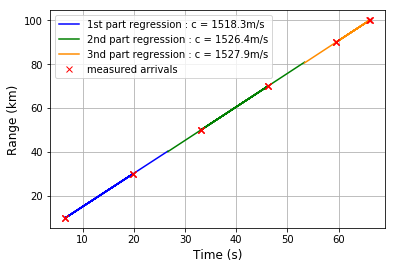

In [332]:
plt.figure()

plt.plot(TT1, RR1/1000., 'b', label = '1st part regression : c = %.1fm/s' %res1[0])
plt.plot(TT2, RR2/1000., 'g', label = '2nd part regression : c = %.1fm/s' %res2[0])
plt.plot(TT3, RR3/1000., 'darkorange', label = '3nd part regression : c = %.1fm/s' %res3[0])
plt.plot(TT, REAL_RANGE/1000., 'xr', label = 'measured arrivals')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Range (km)', fontsize=12)
plt.grid()
plt.legend(fontsize=10)

plt.savefig('reg_lin3_med2', dpi = 100)

---
## Vérifications avec plus de vignettes

In [48]:
### Creat .env file

issp=1                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 11
s.params['NRange'] = 21
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med2_complete.env' )

In [292]:
### read file .arr 
Arr2_prof2, Pos2_prof2 = s.read_arrivals_asc ('files/med2_complete.arr', Narrmx = 340)

Max.number of arrivals for source index 0 is 339


In [293]:
### Reponses impulsionnelles
D = np.arange(50., 450.+1., 50.)         # tous les 50m
R = np.arange(5., 95.+1., 5.)* 1000.     # tous les 5km
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos2_prof2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos2_prof2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  171


In [294]:
# 1er rayon supérieur à 10dB

isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr2_prof2['Narr'][irr,ird,isd])
        amp = Arr2_prof2['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr2_prof2['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        if len(t_ok) != 0 : 
            t_first = np.min(t_ok)
        
            idx_first = np.where(times==t_first)[0][0]
        
            # Chosen ray features
            NumTopBnc_f = Arr2_prof2['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
            NumBotBnc_f = Arr2_prof2['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
            SrcAngle_f  = Arr2_prof2['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
            # Appends
            TopBnc.append(NumTopBnc_f)
            BotBnc.append(NumBotBnc_f)
            SrcAngle.append(SrcAngle_f)
            Tarr.append(t_first)
            
        else : 
            TopBnc.append(np.NaN)
            BotBnc.append(np.NaN)
            SrcAngle.append(np.NaN)
            Tarr.append(np.NaN)

In [295]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d.' %(k, len(BotBnc)))

Nombre de réfélchis fond : 0/171.


#### Avec la régression linéaire précédente

In [262]:
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [263]:
### 3 régressions linéaires correspondant aux trois catégories de rayons

Time = np.array(Tarr)

idx1tot = np.where(REAL_RANGE < 40.*1000.)[0]
idx2tot = np.where(np.logical_and(REAL_RANGE >= 40.*1000., REAL_RANGE < 80.*1000.) )[0]
idx3tot = np.where(REAL_RANGE >= 80.*1000.)[0]


Rtot_inf40 = res1[0] * Time[idx1tot] + res1[1]
Rtot_inf80 = res2[0] * Time[idx2tot] + res2[1]
Rtot_sup80 = res3[0] * Time[idx3tot] + res3[1]


diff_a = REAL_RANGE[idx1tot] - Rtot_inf40
diff_b = REAL_RANGE[idx2tot] - Rtot_inf80
diff_c = REAL_RANGE[idx3tot] - Rtot_sup80

Diff2_tot = np.hstack( (diff_a, diff_b, diff_c) )

In [266]:
### Max value 
print(np.min(abs(Diff2_tot)))

0.07966507689707214


In [267]:
e_t = np.sqrt( np.mean( (Diff2_tot)**2 ) )
e_t

67.54225380326999

In [268]:
### avec une unique régression 
RRR = res[0]*Time + res[1]
ddd = REAL_RANGE - RRR

In [269]:
e_t = np.sqrt( np.mean( (ddd)**2 ) )
e_t

69.87237848012677

In [271]:
print(np.min(abs(ddd)))

0.2693316771037644


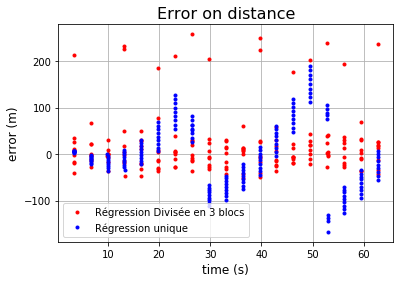

In [296]:
### error on range : real range - range from linear regression
plt.figure()
plt.plot(Time, Diff2_tot, 'r.', label='Régression Divisée en 3 blocs')
plt.plot(Time, ddd, 'b.', label = 'Régression unique')
plt.title('Error on distance',fontsize=16)
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('error (m)',fontsize=12)
plt.grid()
plt.legend()

plt.savefig('error_med2', dpi=100)

In [61]:
### Tableau avec stats : ecart type, mmin, max, mean, ... 


----
---
# Profil N°3 

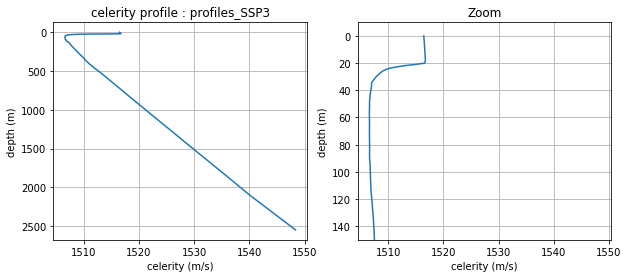

In [297]:
issp=2
s.plotssp('mediterrannee', Issp=issp)
plt.savefig('profile_med3', dpi=100)

In [62]:
### Creat .env file

issp=2                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 6
s.params['NRange'] = 11
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med3.env' )

In [298]:
### read file .arr 
Arr_prof3, Pos_prof3 = s.read_arrivals_asc ('files/med3.arr', Narrmx = 3107)

Max.number of arrivals for source index 0 is 3106


In [436]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_prof2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_prof2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


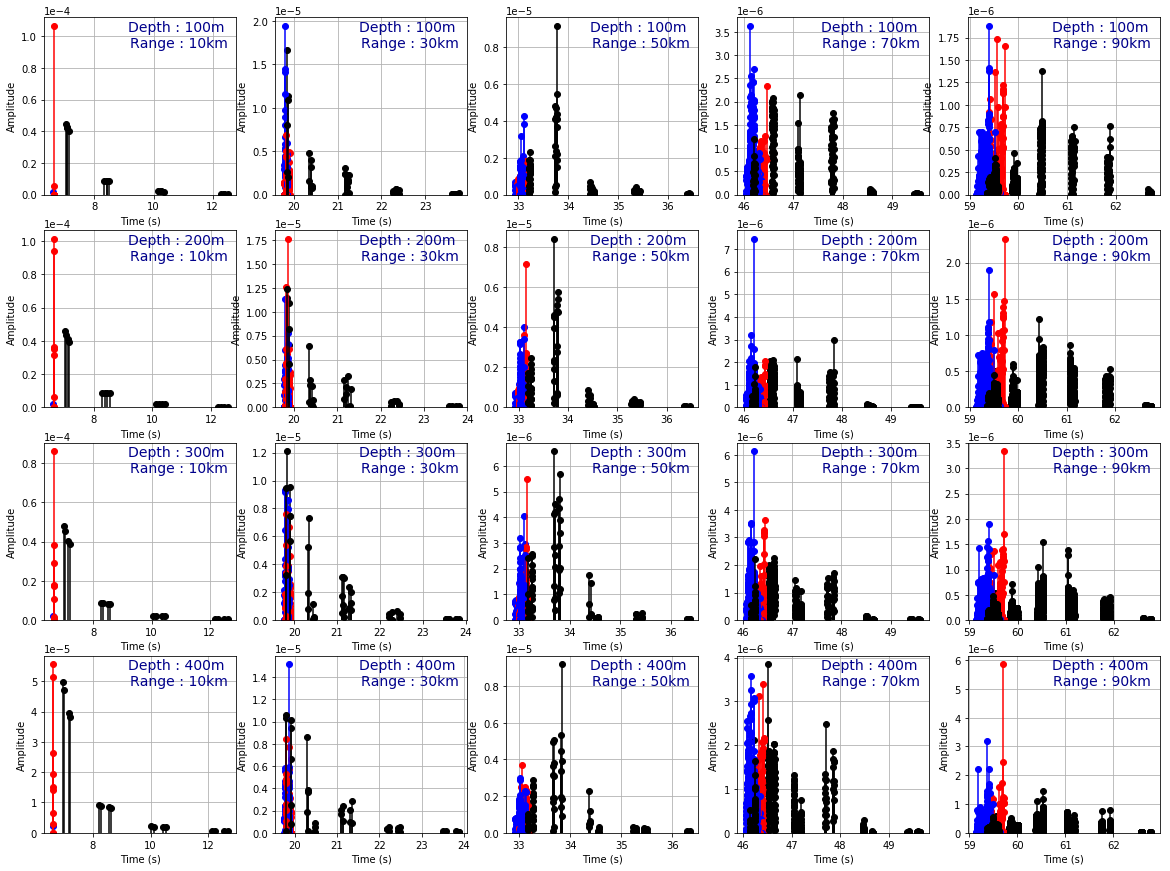

In [334]:
isd = 0       # choice of source depth

Total_time = []
Amp_min = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        s.plotarr(Arr_prof3, Pos_prof3, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr_prof3['Narr'][irr,ird,isd])
        amp = Arr_prof3['A'][irr,:Narr, ird, isd]
        Amp_min.append(np.min(abs(amp)))
        times = Arr_prof3['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))
        
plt.savefig('vignettes_med3', dpi=100)

### Zoom

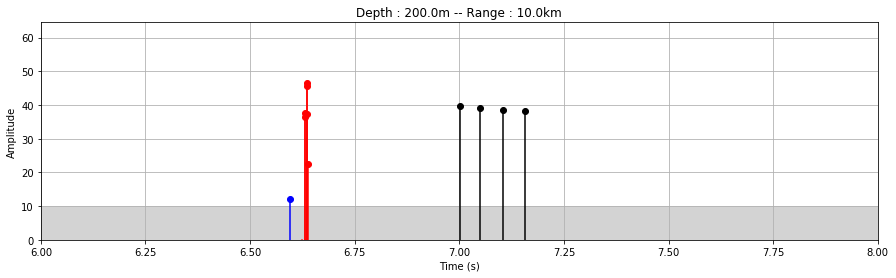

In [66]:
ird = 2       # depth : 300m    
irr = 1       # range : 50km  

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
Narr = int(Arr_prof3['Narr'][irr, ird, isd])
for i in range (Narr) : 
    t = Arr_prof3['delay'][irr, i, ird, isd]
    TL = -20*np.log10 (abs(Arr_prof3['A'][irr, i, ird, isd]))
    RL = SL - TL -NL +DI + PG
    markerline, stemlines, baseline = plt.stem( [t], [RL])            

    if np.logical_and ( Arr_prof3['NumTopBnc'][irr, i,ird,isd] == 0, Arr_prof3['NumBotBnc'][irr, i,ird,isd] == 0):
        plt.setp(stemlines, color = 'r')
        plt.setp(markerline, color = 'r')

    elif Arr_prof3['NumBotBnc'][irr, i,ird,isd] == 0:
        plt.setp(stemlines, color = 'b')
        plt.setp(markerline, color = 'b')

    else : 
        plt.setp(stemlines, color = 'k')
        plt.setp(markerline, color = 'k')

plt.ylim(ymin=0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Source depth : %.1fm -- Receiver depth : %.1fm -- Receiver range : %.1fkm' \
#          % (Pos['s']['depth'][isd], Pos['r']['depth'][ird], Pos['r']['range'][irr]/1000.))
plt.title('Depth : %.1fm -- Range : %.1fkm' %(Pos_prof3['r']['depth'][ird], Pos_prof3['r']['range'][irr]/1000.))
plt.grid()
plt.xlim([6., 8.])
#plt.xlim([19.7,20.])
#plt.xlim([33., 33.9])
#plt.xlim([46.,55.])
#plt.xlim([59.4,59.6])

ax.fill_between(np.array([0.,75.]), np.array([10., 10.]), facecolor='lightgrey')

## CHOIX de la méthode de détection : 1er rayon > 10 dB

In [437]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 80., 90., 100.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_prof2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_prof2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  28


In [438]:
isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr_prof3['Narr'][irr,ird,isd])
        amp = Arr_prof3['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr_prof3['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        t_first = np.min(t_ok)
        idx_first = np.where(times==t_first)[0][0]

        
        # Chosen ray features
        NumTopBnc_f = Arr_prof3['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
        NumBotBnc_f = Arr_prof3['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
        SrcAngle_f  = Arr_prof3['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
        # Appends
        TopBnc.append(NumTopBnc_f)
        BotBnc.append(NumBotBnc_f)
        SrcAngle.append(SrcAngle_f)
        Tarr.append(t_first)

In [439]:
k = True
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k = False
print ('Pas de réfélchis fond : %s.' %k)

Pas de réfélchis fond : True.


In [440]:
n = R.size
print('Nombre de rebonds sur la surface : \n')
print ('                 10km     30km     50km     70km    80km      90km     100km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d        %d        %d        %d      %d        %d         %d' %(D[i], TopBnc[n*i], \
                                                                TopBnc[n*i+1], TopBnc[n*i+2], \
                                                                TopBnc[n*i+3], TopBnc[n*i+4], \
                                                                TopBnc[n*i+5], TopBnc[n*i+6]))

Nombre de rebonds sur la surface : 

                 10km     30km     50km     70km    80km      90km     100km

  Depth = 100m :   1        1        1        2      2        3         2
  Depth = 200m :   1        1        1        2      2        3         2
  Depth = 300m :   1        1        1        2      2        3         3
  Depth = 400m :   1        1        1        2      0        3         3


In [441]:
#### On va donc faire 3 régressions linéaires ... 

In [442]:
### On connaît le temps d'arrivée et le range correspondant pour les 20 vignettes
TT = np.array(Tarr)
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [443]:
### 3 régressions linéaires correspondant aux trois catégories de rayons

idx1 = np.where(REAL_RANGE < 60.*1000.)[0]
idx2 = np.where(np.logical_and(REAL_RANGE >= 60.*1000., REAL_RANGE < 90.*1000.) )[0]
idx3 = np.where(REAL_RANGE >= 90.*1000.)[0]

res1 = np.polyfit(TT[idx1], REAL_RANGE[idx1],1)
res2 = np.polyfit(TT[idx2], REAL_RANGE[idx2],1)
res3 = np.polyfit(TT[idx3], REAL_RANGE[idx3],1)


Rreg_inf60 = res1[0] * TT[idx1] + res1[1]
Rreg_inf90 = res2[0] * TT[idx2] + res2[1]
Rreg_sup90 = res3[0] * TT[idx3] + res3[1]

diff_a = REAL_RANGE[idx1] - Rreg_inf60
diff_b = REAL_RANGE[idx2] - Rreg_inf90
diff_c = REAL_RANGE[idx3] - Rreg_sup90

Diff2 = np.hstack( (diff_a, diff_b, diff_c) )

In [444]:
e_t = np.sqrt( np.mean( (Diff2)**2 ) )
e_t

69.60007506894229

In [445]:
TT1 = np.hstack ((TT[idx1], np.array(60000./1500.)))
RR1 = np.hstack((Rreg_inf60, np.array(res1[0]*60000./1500.+res1[1])))

TT2 = np.hstack (np.hstack((np.array(60000./1500.), (TT[idx2], np.array(90000./1500.)))))
RR2 = np.hstack (np.hstack((np.array(res2[0]*60000./1500.+res2[1]), \
                           (Rreg_inf90, np.array(res2[0]*90000./1500.+res2[1])))))

TT3 = np.hstack ((np.array(90000./1500.), TT[idx3]))
RR3 = np.hstack((np.array(res3[0]*90000./1500.+res3[1]), Rreg_sup90))

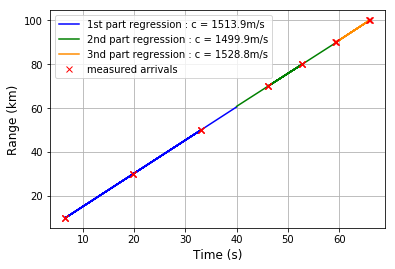

In [446]:
plt.figure()

plt.plot(TT1, RR1/1000., 'b', label = '1st part regression : c = %.1fm/s' %res1[0])
plt.plot(TT2, RR2/1000., 'g', label = '2nd part regression : c = %.1fm/s' %res2[0])
plt.plot(TT3, RR3/1000., 'darkorange', label = '3nd part regression : c = %.1fm/s' %res3[0])
plt.plot(TT, REAL_RANGE/1000., 'xr', label = 'measured arrivals')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Range (km)', fontsize=12)
plt.grid()
plt.legend(fontsize=10)

plt.savefig('reg_lin3_med3', dpi = 100)

In [447]:
res = np.polyfit(TT, REAL_RANGE,1)
Rreg = res[0] * TT + res[1]
Diff = REAL_RANGE - Rreg

In [448]:
e_t = np.sqrt( np.mean( (Diff)**2 ) )
e_t

83.80782756245746

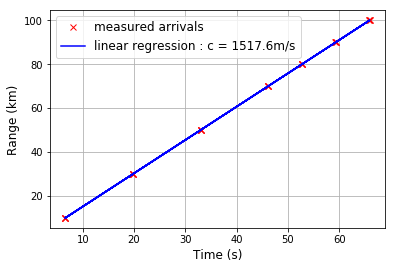

In [449]:
plt.figure()
plt.plot(TT, REAL_RANGE/1000., 'xr', label = 'measured arrivals')
plt.plot(TT, Rreg/1000., 'b', label = 'linear regression : c = %.1fm/s' %res[0])
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Range (km)', fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('reg_lin1_med3', dpi = 100)

### Verif avec plus de vignettes

In [89]:
### Creat .env file

issp=2                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 11
s.params['NRange'] = 21
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med3_complete.env' )

In [361]:
### read file .arr 
Arr2_prof3, Pos2_prof3 = s.read_arrivals_asc ('files/med3_complete.arr', Narrmx = 3107)

Max.number of arrivals for source index 0 is 3106


In [450]:
### Reponses impulsionnelles
D = np.arange(50., 450.+1., 50.)         # tous les 50m
R = np.arange(5., 95.+1., 5.)* 1000.     # tous les 5km
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos2_prof3['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos2_prof3['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  171


In [451]:
# 1er rayon supérieur à 10dB

isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr2_prof3['Narr'][irr,ird,isd])
        amp = Arr2_prof3['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr2_prof3['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        if len(t_ok) != 0 : 
            t_first = np.min(t_ok)
        
            idx_first = np.where(times==t_first)[0][0]
        
            # Chosen ray features
            NumTopBnc_f = Arr2_prof3['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
            NumBotBnc_f = Arr2_prof3['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
            SrcAngle_f  = Arr2_prof3['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
            # Appends
            TopBnc.append(NumTopBnc_f)
            BotBnc.append(NumBotBnc_f)
            SrcAngle.append(SrcAngle_f)
            Tarr.append(t_first)
            
        else : 
            TopBnc.append(np.NaN)
            BotBnc.append(np.NaN)
            SrcAngle.append(np.NaN)
            Tarr.append(np.NaN)

In [452]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d.' %(k, len(BotBnc)))

Nombre de réfélchis fond : 1/171.


In [453]:
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [454]:
Time = np.array(Tarr)

idx1tot = np.where(REAL_RANGE < 60.*1000.)[0]
idx2tot = np.where(np.logical_and(REAL_RANGE >= 60.*1000., REAL_RANGE < 90.*1000.) )[0]
idx3tot = np.where(REAL_RANGE >= 90.*1000.)[0]


Rtot_inf60 = res1[0] * Time[idx1tot] + res1[1]
Rtot_inf90 = res2[0] * Time[idx2tot] + res2[1]
Rtot_sup90 = res3[0] * Time[idx3tot] + res3[1]


diff_a = REAL_RANGE[idx1tot] - Rtot_inf60
diff_b = REAL_RANGE[idx2tot] - Rtot_inf90
diff_c = REAL_RANGE[idx3tot] - Rtot_sup90

Diff3_tot = np.hstack( (diff_a, diff_b, diff_c) )

In [455]:
e_t = np.sqrt( np.mean( (Diff3_tot)**2 ) )
e_t

109.47545456349138

In [456]:
sort = sorted(abs(Diff3_tot))   # Dernière valeur à 1109m...
e_t = np.sqrt( np.mean( (np.array(sort[:-1]))**2 ) )
e_t

69.36427445402575

In [457]:
np.max(sort[:-1])

243.59345608168223

In [458]:
Rtot = res[0] * Time + res[1]
Diff_tot = REAL_RANGE - Rtot

In [459]:
np.max(abs(Diff3_tot))

1109.7185291691421

In [460]:
e_t = np.sqrt( np.mean( (Diff_tot)**2 ) )
e_t

115.08263297324159

In [461]:
sort = sorted(abs(Diff_tot))   # Dernière valeur à 1109m...
e_t = np.sqrt( np.mean( (np.array(sort[:-1]))**2 ) )
e_t

72.17773524529773

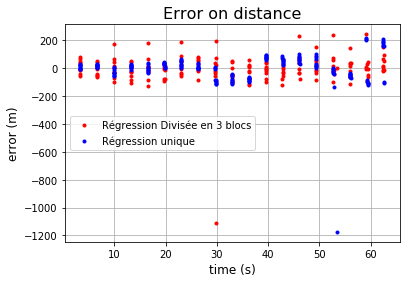

In [462]:
### error on range : real range - range from linear regression
plt.figure()
plt.plot(Time, Diff3_tot, 'r.', label='Régression Divisée en 3 blocs')
plt.plot(Time, Diff_tot, 'b.', label='Régression unique')
plt.title('Error on distance',fontsize=16)
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('error (m)',fontsize=12)
plt.grid()
plt.legend()

plt.savefig('erreur_med3', dpi=100)

In [88]:
### Seulement le réfléchi fond qui entraîne une erreur de 1100m...

# Profil n°4

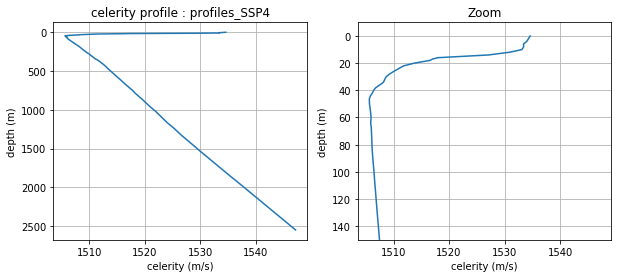

In [388]:
issp=3
s.plotssp('mediterrannee', Issp=issp)
plt.savefig('profile_med4', dpi=100)

In [110]:
### Creat .env file

issp=3                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 6
s.params['NRange'] = 11
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med4.env' )

In [206]:
### read file .arr 
Arr_prof4, Pos_prof4 = s.read_arrivals_asc ('files/med4.arr', Narrmx = 4313)

Max.number of arrivals for source index 0 is 4312


In [207]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_prof4['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_prof4['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


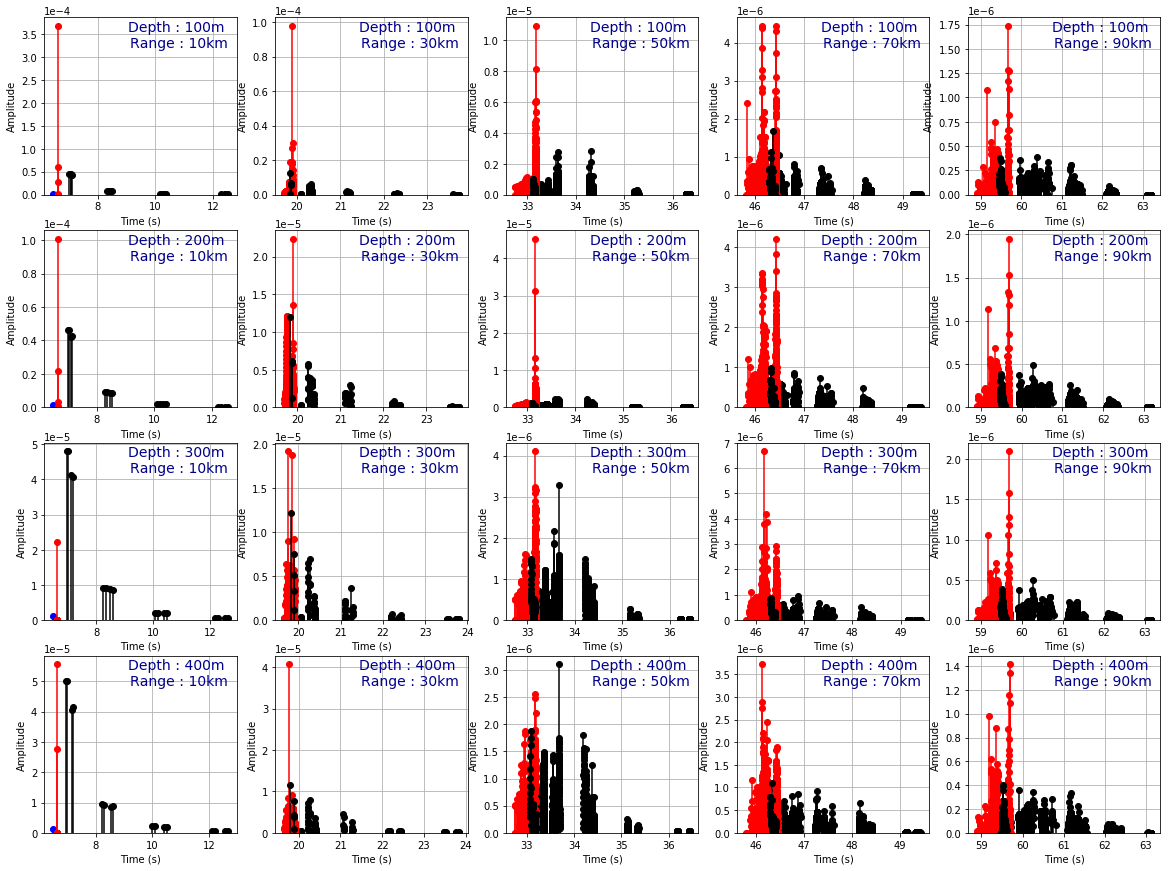

In [391]:
isd = 0       # choice of source depth

Total_time = []
Amp_min = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        s.plotarr(Arr_prof4, Pos_prof4, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr_prof4['Narr'][irr,ird,isd])
        amp = Arr_prof4['A'][irr,:Narr, ird, isd]
        Amp_min.append(np.min(abs(amp)))
        times = Arr_prof4['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))

plt.savefig('vignettes_med4', dpi=100)

### Zoom

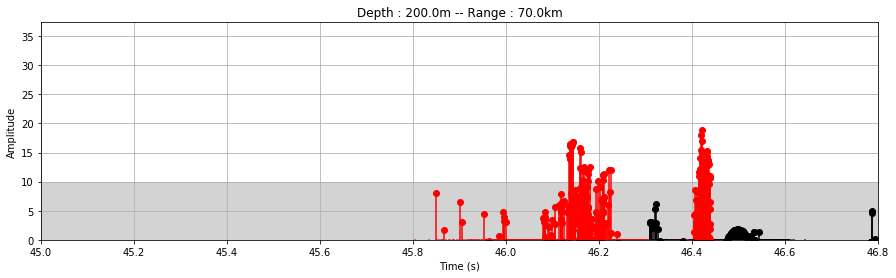

In [113]:
ird = 2       # depth : 300m    
irr = 7       # range : 50km  

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
Narr = int(Arr_prof4['Narr'][irr, ird, isd])
for i in range (Narr) : 
    t = Arr_prof4['delay'][irr, i, ird, isd]
    TL = -20*np.log10 (abs(Arr_prof4['A'][irr, i, ird, isd]))
    RL = SL - TL -NL +DI + PG
    markerline, stemlines, baseline = plt.stem( [t], [RL])            

    if np.logical_and ( Arr_prof4['NumTopBnc'][irr, i,ird,isd] == 0, Arr_prof4['NumBotBnc'][irr, i,ird,isd] == 0):
        plt.setp(stemlines, color = 'r')
        plt.setp(markerline, color = 'r')

    elif Arr_prof4['NumBotBnc'][irr, i,ird,isd] == 0:
        plt.setp(stemlines, color = 'b')
        plt.setp(markerline, color = 'b')

    else : 
        plt.setp(stemlines, color = 'k')
        plt.setp(markerline, color = 'k')

plt.ylim(ymin=0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Source depth : %.1fm -- Receiver depth : %.1fm -- Receiver range : %.1fkm' \
#          % (Pos['s']['depth'][isd], Pos['r']['depth'][ird], Pos['r']['range'][irr]/1000.))
plt.title('Depth : %.1fm -- Range : %.1fkm' %(Pos_prof4['r']['depth'][ird], Pos_prof4['r']['range'][irr]/1000.))
plt.grid()
#plt.xlim([6., 7.5])
#plt.xlim([19.7,20.])
#plt.xlim([33., 33.9])
plt.xlim([45.,46.8])
#plt.xlim([59.4,59.6])

ax.fill_between(np.array([0.,75.]), np.array([10., 10.]), facecolor='lightgrey')

## Choix de la méthode de détection :  max d'amplitude

In [208]:
isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr_prof4['Narr'][irr,ird,isd])
        amp = Arr_prof4['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr_prof4['delay'][irr, :Narr, ird, isd]
        #idx = np.where(RL > 10.)
        #t_ok = times[idx]
        
        #if len(t_ok)>0 : 
            #t_first = np.min(t_ok)
            #idx_first = np.where(times==t_first)[0][0]
            

            # Chosen ray features
            #NumTopBnc_f = Arr_prof4['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
            #NumBotBnc_f = Arr_prof4['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
            #SrcAngle_f  = Arr_prof4['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
            # Appends
            #TopBnc.append(NumTopBnc_f)
            #BotBnc.append(NumBotBnc_f)
            #SrcAngle.append(SrcAngle_f)
            #Tarr.append(t_first) 
                
        #else : 
            #TopBnc.append(np.NaN)
            #BotBnc.append(np.NaN)
            #SrcAngle.append(np.NaN)
            #Tarr.append(np.NaN)
            
        
        idx_first = np.where(RL==np.max(RL))[0][0]
        
        NumTopBnc_f = Arr_prof4['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
        NumBotBnc_f = Arr_prof4['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
        SrcAngle_f  = Arr_prof4['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
        TopBnc.append(NumTopBnc_f)
        BotBnc.append(NumBotBnc_f)
        SrcAngle.append(SrcAngle_f)
        Tarr.append(times[idx_first])


In [209]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d.' %(k, len(BotBnc)))

Nombre de réfélchis fond : 2/20.


In [210]:
n = R.size
print('Nombre de réfléxions sur la surface : \n')
print ('                 10km     30km     50km      70km     90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d        %d        %d        %d        %d' %(D[i], TopBnc[n*i], \
                                                                TopBnc[n*i+1], TopBnc[n*i+2], \
                                                                TopBnc[n*i+3], TopBnc[n*i+4]))

Nombre de réfléxions sur la surface : 

                 10km     30km     50km      70km     90km

  Depth = 100m :   0        0        0        0        0
  Depth = 200m :   0        0        0        0        0
  Depth = 300m :   1        0        0        0        0
  Depth = 400m :   0        0        3        0        0


In [211]:
### On connaît le temps d'arrivée et le range correspondant pour les 20 vignettes
TT = np.array(Tarr)
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [212]:
### 1 régression linéaire
res = np.polyfit(TT[~np.isnan(TT)], REAL_RANGE[~np.isnan(TT)],1)
Rreg = res[0] * TT + res[1]
Diff = REAL_RANGE - Rreg

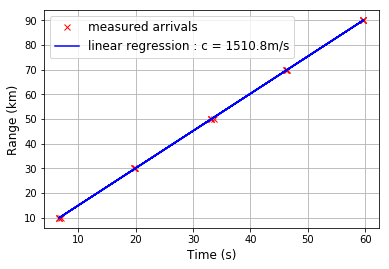

In [213]:
plt.figure()
plt.plot(TT, REAL_RANGE/1000., 'xr', label = 'measured arrivals')
plt.plot(TT, Rreg/1000., 'b', label = 'linear regression : c = %.1fm/s' %res[0])
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Range (km)', fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('reg_lin1_med4', dpi = 100)

In [398]:
Diff

array([  80.3814659 ,   36.55907039,   -2.85575969,  -31.58258389,
        -38.31652787,   93.16164253,   35.70908211,   -5.70290316,
        -26.98334051,  -71.92823121, -486.20188269,  254.89697744,
        -11.41426238,  338.0946338 ,  -73.19037165,  101.96512496,
        228.81505831, -783.83846937,  436.88378908,  -74.45251209])

In [214]:
# régression linéaire avec les non-reflechis fond seulement

BotBnc
idx_dir = [] 
for i in range(len(BotBnc)):
    if BotBnc[i] == 0. :
        idx_dir.append(i)
        
Tdir = TT[idx_dir]
REAL_RANGEdir = REAL_RANGE[idx_dir]

res1 = np.polyfit(Tdir, REAL_RANGEdir,1)
Rreg1 = res1[0] * TT + res1[1]
Diff1 = REAL_RANGE - Rreg1

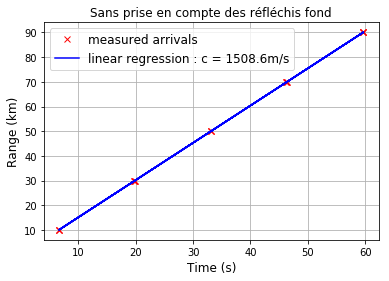

In [219]:
plt.figure()
plt.plot(Tdir, REAL_RANGEdir/1000., 'xr', label = 'measured arrivals')
plt.plot(TT, Rreg1/1000., 'b', label = 'linear regression : c = %.1fm/s' %res1[0])
plt.title('Sans prise en compte des réfléchis fond')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Range (km)', fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('reg_lin1_med4', dpi = 100)

In [399]:
n = R.size
print('Diff : \n')
print ('                 10km       30km       50km        70km       90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %3d        %3d        %3d        %3d        %3d' %(D[i], Diff[n*i], \
                                                                Diff[n*i+1], Diff[n*i+2], \
                                                                Diff[n*i+3], Diff[n*i+4]))

Diff : 

                 10km       30km       50km        70km       90km

  Depth = 100m :    80         36         -2        -31        -38
  Depth = 200m :    93         35         -5        -26        -71
  Depth = 300m :   -486        254        -11        338        -73
  Depth = 400m :   101        228        -783        436        -74


In [400]:
e_t = np.sqrt( np.mean( (Diff[~np.isnan(Diff)])**2 ) )
e_t

256.9909009958633

In [401]:
n = R.size
print('Range from regression : \n')
print ('                 10km          30km         50km          70km         90km\n')
for i in range(D.size) :   
    print('  Depth = %dm :   %d        %d        %d        %d        %d' %(D[i], Rreg[n*i], \
                                                                Rreg[n*i+1], Rreg[n*i+2], \
                                                                Rreg[n*i+3], Rreg[n*i+4]))

Range from regression : 

                 10km          30km         50km          70km         90km

  Depth = 100m :   9919        29963        50002        70031        90038
  Depth = 200m :   9906        29964        50005        70026        90071
  Depth = 300m :   10486        29745        50011        69661        90073
  Depth = 400m :   9898        29771        50783        69563        90074


In [403]:
#ird = 2   # *100 = depth (m)
#irr = 9   # *10 = range (km)

Dist = []
list_R = []
list_Z = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        

        # angle surlequel on travaille

        idx_d = np.where(D==ird*100.)[0][0]
        idx_r = np.where(R==irr*10.*1000.)[0][0]
        angle = SrcAngle[R.size*idx_d + idx_r]

        ### Creat .env file E

        issp=0                          # sound speed profile number
        s.params['file_type'] = 'E'
        s.params['ALimites'] = [angle]

        s.params['zmin'] = Pos1['r']['depth'][ird]          # receiver depth (m)
        s.params['rmin'] = Pos1['r']['range'][irr]/1000.    # receiver range (km)  

        s.params['NDepth'] = 1
        s.params['NRange'] = 1
        s.params['NBeams'] = 2

        s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1_E.env' )
        
        ### execute bellhop
        subprocess.call(["bellhop.exe", 'med1_E'])
        
        ### output .ray file
        dictE = s.plotE ('med1_E.ray', plot = False)
        angles_E = dictE['SrcAngle']
        

        ### distance correspondante  
        if angles_E.size == 1 : 
            dist = dictE['Dist'][0]
            rr = dictE['R'].squeeze()[0,:]
            zz = dictE['Z'].squeeze()[0,:]
        else :
            dist = dictE['Dist'][np.where(angles_E !=0.)][0]
            rr = dictE['R'].squeeze()[np.where(angles_E !=0.),:]
            zz = dictE['Z'].squeeze()[np.where(angles_E !=0.),:]
            
        
        Dist.append(dist)
        list_R.append(rr)
        list_Z.append(zz)
        
list_R = np.array(list_R).squeeze()
list_Z = np.array(list_Z).squeeze()

In [404]:
dictE['R'].shape

(1, 2, 4000)

In [405]:
dictE['Dist'][np.where(angles_E !=0.)]

array([90128.3630012])

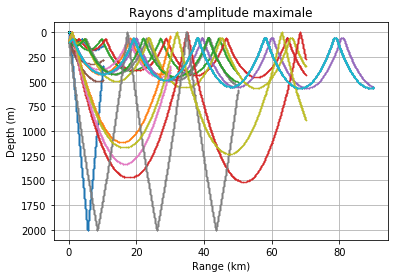

In [434]:
plt.figure()
for i in range (list_R.shape[0]) : 
    plt.plot (list_R[i,:]/1000., list_Z[i,:],'.', markersize=1)

plt.title ("Rayons d'amplitude maximale")
plt.xlabel('Range (km)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.grid()

plt.savefig('rayons_med4', dpi=100)


In [624]:
#PROF = np.zeros(D.size*R.size)
#for k in range (D.size) :
#    PROF[k*R.size:(k+1)*R.size] = D[k]

In [ ]:
### Pas de relation linéaire entre distance parcourue et profondeur (à un range fixé)...

### Avec plus de vignettes

In [127]:
### Creat .env file

issp=3                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 11
s.params['NRange'] = 21
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med4_complete.env' )

In [220]:
### read file .arr 
Arr2_prof4, Pos2_prof4 = s.read_arrivals_asc ('files/med4_complete.arr', Narrmx = 4335)

Max.number of arrivals for source index 0 is 4334


In [221]:
### Reponses impulsionnelles
D = np.arange(50., 450.+1., 50.)         # tous les 50m
R = np.arange(5., 95.+1., 5.)* 1000.     # tous les 5km
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos2_prof4['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos2_prof4['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  171


In [418]:
# 1er rayon supérieur à 10dB

isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr2_prof4['Narr'][irr,ird,isd])
        amp = Arr2_prof4['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr2_prof4['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        if len(t_ok) != 0 : 
            t_first = np.min(t_ok)
        
            idx_first = np.where(times==t_first)[0][0]
        
            # Chosen ray features
            NumTopBnc_f = Arr2_prof4['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
            NumBotBnc_f = Arr2_prof4['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
            SrcAngle_f  = Arr2_prof4['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
            # Appends
            TopBnc.append(NumTopBnc_f)
            BotBnc.append(NumBotBnc_f)
            SrcAngle.append(SrcAngle_f)
            Tarr.append(t_first)
            
        else : 
            TopBnc.append(np.NaN)
            BotBnc.append(np.NaN)
            SrcAngle.append(np.NaN)
            Tarr.append(np.NaN)

In [222]:
isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr2_prof4['Narr'][irr,ird,isd])
        amp = Arr2_prof4['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr2_prof4['delay'][irr, :Narr, ird, isd]
        idx_first = np.where(RL==np.max(RL))[0][0]
        
        NumTopBnc_f = Arr2_prof4['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
        NumBotBnc_f = Arr2_prof4['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
        SrcAngle_f  = Arr2_prof4['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
        TopBnc.append(NumTopBnc_f)
        BotBnc.append(NumBotBnc_f)
        SrcAngle.append(SrcAngle_f)
        Tarr.append(times[idx_first])

In [223]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d. ' %(k, len(BotBnc)))
print ('    Ce qui représente %.1f' %( k/len(BotBnc)*100.) + '% des rayons.')

Nombre de réfélchis fond : 16/171. 
    Ce qui représente 9.4% des rayons.


In [224]:
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [225]:
Time = np.array(Tarr)

Rtot = res[0]* Time + res[1]
Diff_tot = REAL_RANGE - Rtot

In [226]:
np.min(abs(Diff_tot))

0.6149392761508352

In [227]:
e_t = np.sqrt( np.mean( (Diff_tot)**2 ) )
e_t

280.3448400677315

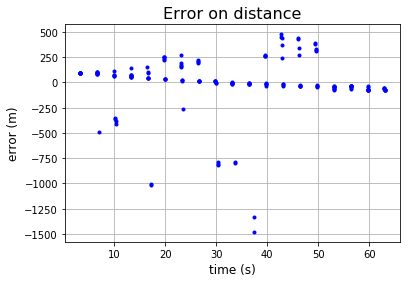

In [228]:
### error on range : real range - range from linear regression
plt.figure()
#plt.plot(Time, Diff3_tot, 'b.', label='Régression Divisée en 3 blocs')
plt.plot(Time, Diff_tot, 'b.', label='Régression unique')
plt.title('Error on distance',fontsize=16)
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('error (m)',fontsize=12)
plt.grid()
#plt.legend(loc=4)

plt.savefig('erreur_med4', dpi=100)

In [229]:
Rtot1 = res1[0]* Time + res1[1]
Diff_tot1 = REAL_RANGE - Rtot1

In [235]:
np.max(abs(Diff_tot1))

1544.4133607739277

In [232]:
e_t = np.sqrt( np.mean( (Diff_tot1)**2 ) )
e_t

293.2757362368016

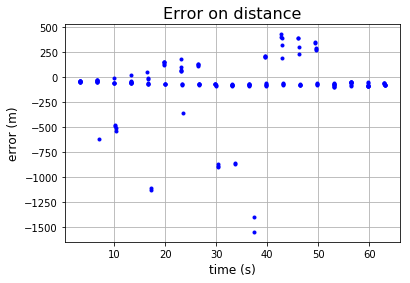

In [234]:
### error on range : real range - range from linear regression
plt.figure()
#plt.plot(Time, Diff3_tot, 'b.', label='Régression Divisée en 3 blocs')
plt.plot(Time, Diff_tot1, 'b.', label='Régression unique')
plt.title('Error on distance',fontsize=16)
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('error (m)',fontsize=12)
plt.grid()
#plt.legend(loc=4)

plt.savefig('erreur_med4', dpi=100)

In [ ]:
#### Les très grands erreurs entre -250 et -1500m correspondent aux réfléchis-fond.
#        ---> est-ce une erreur de calcul d'amplitude de bellhop ou pas ?

### Les pics d'erreurs autour de 30 et 70km correspondent aux zones de résurgence.

### La régression n'est pas optimale car on prend en compte des valeurs dans les zones de résurgence...

### Dans la réalité pourra-t-on séparer les différents pics et éviter de détecter les zones de résurgence ?

---
----
# Profil Gulf Stream n°1

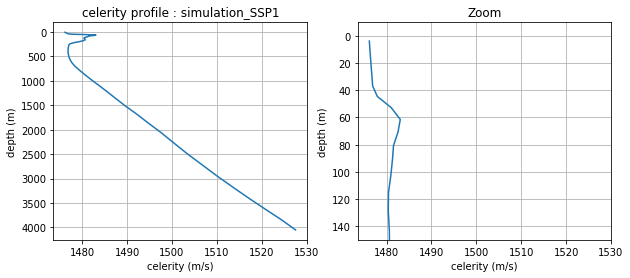

In [15]:
issp = 0
g1.plotssp('gs', Issp=issp)
plt.savefig('profile_gs1', dpi=100)

In [158]:
### Creat .env file

issp=0                          # sound speed profile number
g1.params['file_type'] = 'A'
g1.params['ALimites'] = [-60.0, 60.0]

g1.params['zmin'] = 0.
g1.params['rmin'] = 0.
g1.params['NDepth'] = 6
g1.params['NRange'] = 11
g1.params['NBeams'] = 12000

g1.generate_envfile('gs',Issp=issp, SSP_depth_step=1, file_env = 'gs1.env' )

In [9]:
### read file .arr 
Arr_gs1, Pos_gs1 = s.read_arrivals_asc ('files/gs1.arr', Narrmx = 105)

Max.number of arrivals for source index 0 is 104


In [191]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_gs1['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_gs1['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


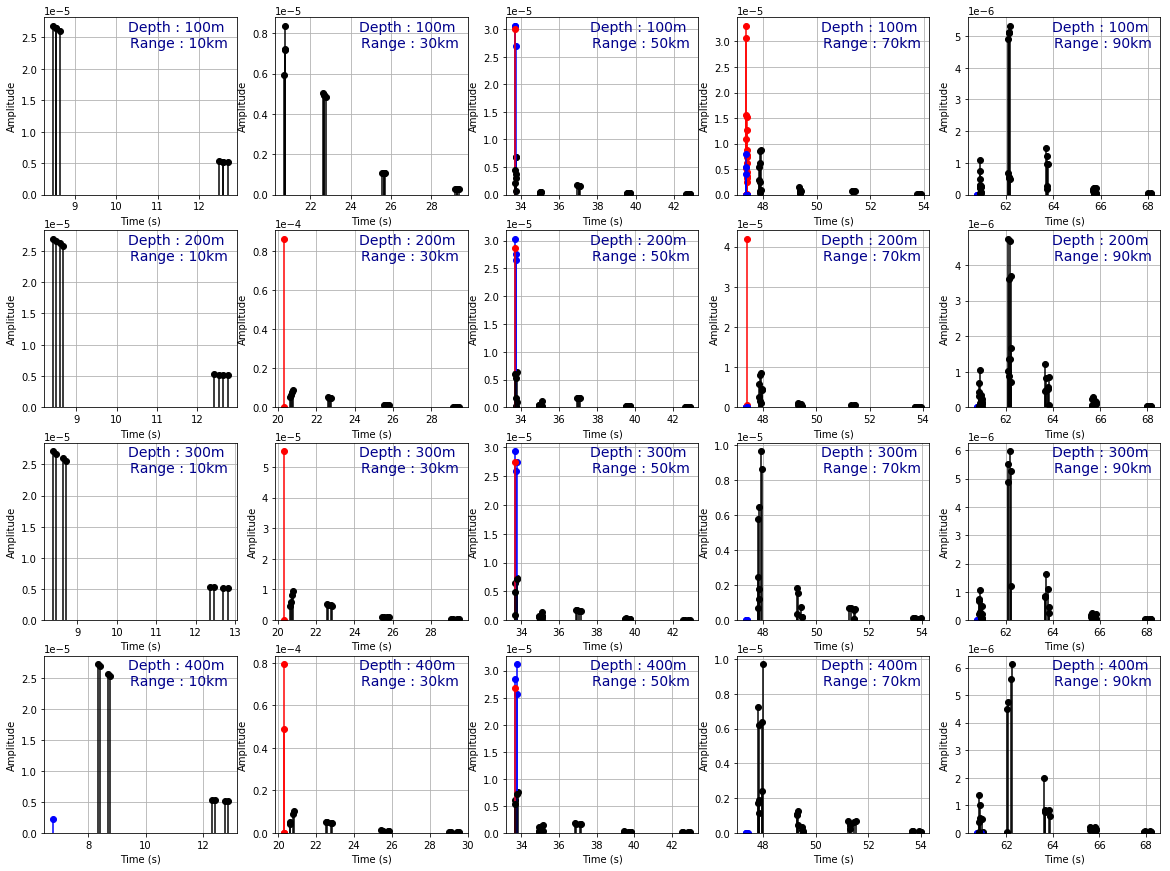

In [12]:
isd = 0       # choice of source depth

Total_time = []
Amp_min = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        s.plotarr(Arr_gs1, Pos_gs1, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr_gs1['Narr'][irr,ird,isd])
        amp = Arr_gs1['A'][irr,:Narr, ird, isd]
        Amp_min.append(np.min(abs(amp)))
        times = Arr_gs1['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))
        
plt.savefig('vignettes_gs1', dpi=100)

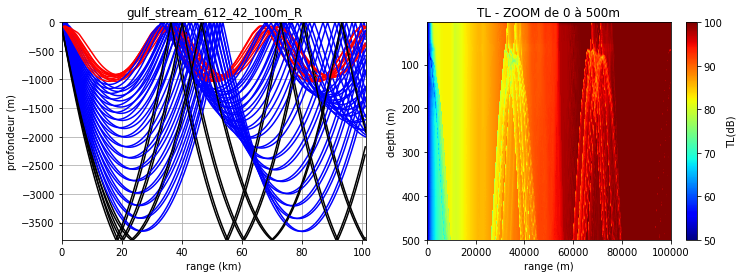

In [14]:
g1.plot_all(file_ray = '../Partie1_Profondeur_source/files/gulf_stream_612_42_100m_R.ray', \
           file_shd = '../Partie1_Profondeur_source/files/gulf_stream_612_42_100m_IB.shd')

plt.savefig('rayons_gs1', dpi=100)

### Zoom

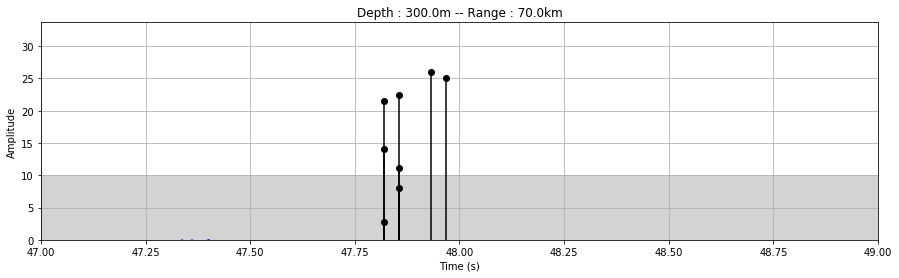

In [166]:
ird = 3       # depth : 300m    
irr = 7       # range : 50km  

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
Narr = int(Arr_gs1['Narr'][irr, ird, isd])
for i in range (Narr) : 
    t = Arr_gs1['delay'][irr, i, ird, isd]
    TL = -20*np.log10 (abs(Arr_gs1['A'][irr, i, ird, isd]))
    RL = SL - TL -NL +DI + PG
    markerline, stemlines, baseline = plt.stem( [t], [RL])            

    if np.logical_and ( Arr_gs1['NumTopBnc'][irr, i,ird,isd] == 0, Arr_gs1['NumBotBnc'][irr, i,ird,isd] == 0):
        plt.setp(stemlines, color = 'r')
        plt.setp(markerline, color = 'r')

    elif Arr_gs1['NumBotBnc'][irr, i,ird,isd] == 0:
        plt.setp(stemlines, color = 'b')
        plt.setp(markerline, color = 'b')

    else : 
        plt.setp(stemlines, color = 'k')
        plt.setp(markerline, color = 'k')

plt.ylim(ymin=0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Source depth : %.1fm -- Receiver depth : %.1fm -- Receiver range : %.1fkm' \
#          % (Pos['s']['depth'][isd], Pos['r']['depth'][ird], Pos['r']['range'][irr]/1000.))
plt.title('Depth : %.1fm -- Range : %.1fkm' %(Pos_gs1['r']['depth'][ird], Pos_gs1['r']['range'][irr]/1000.))
plt.grid()
#plt.xlim([6., 7.5])
#plt.xlim([19.7,20.])
#plt.xlim([33., 33.9])
plt.xlim([47.,49])
#plt.xlim([59.4,59.6])

ax.fill_between(np.array([0.,75.]), np.array([10., 10.]), facecolor='lightgrey')

In [192]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_gs1['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_gs1['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


In [193]:
isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr_gs1['Narr'][irr,ird,isd])
        amp = Arr_gs1['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr_gs1['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        t_first = np.min(t_ok)
        idx_first = np.where(times==t_first)[0][0]

        
        # Chosen ray features
        NumTopBnc_f = Arr_gs1['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
        NumBotBnc_f = Arr_gs1['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
        SrcAngle_f  = Arr_gs1['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
        # Appends
        TopBnc.append(NumTopBnc_f)
        BotBnc.append(NumBotBnc_f)
        SrcAngle.append(SrcAngle_f)
        Tarr.append(t_first)

In [194]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d.' %(k, len(BotBnc)))

Nombre de réfélchis fond : 10/20.


In [195]:
n = R.size
print('Nombre de réfléxions sur la surface : \n')
print ('                 10km     30km     50km      70km     90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d        %d        %d        %d        %d' %(D[i], TopBnc[n*i], \
                                                                TopBnc[n*i+1], TopBnc[n*i+2], \
                                                                TopBnc[n*i+3], TopBnc[n*i+4]))

Nombre de réfléxions sur la surface : 

                 10km     30km     50km      70km     90km

  Depth = 100m :   0        0        0        2        2
  Depth = 200m :   0        0        0        0        2
  Depth = 300m :   0        0        0        1        2
  Depth = 400m :   1        0        0        1        2


In [196]:
### On connaît le temps d'arrivée et le range correspondant pour les 20 vignettes
TT = np.array(Tarr)
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [197]:
### regression linéaire 
### 1 régression linéaire
res = np.polyfit(TT[~np.isnan(TT)], REAL_RANGE[~np.isnan(TT)],1)
Rreg = res[0] * TT + res[1]
Diff = REAL_RANGE - Rreg


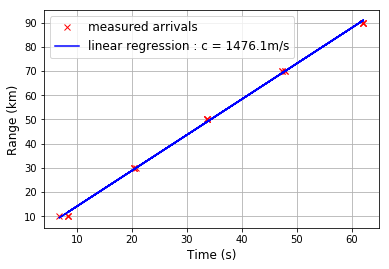

In [198]:
plt.figure()
plt.plot(TT, REAL_RANGE/1000., 'xr', label = 'measured arrivals')
plt.plot(TT, Rreg/1000., 'b', label = 'linear regression : c = %.1fm/s' %res[0])
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Range (km)', fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('reg_lin1_gs1', dpi = 100)

In [199]:
# régression linéaire avec les non-reflechis fond seulement

BotBnc
idx_dir = [] 
for i in range(len(BotBnc)):
    if BotBnc[i] == 0. :
        idx_dir.append(i)
        
Tdir = TT[idx_dir]
REAL_RANGEdir = REAL_RANGE[idx_dir]

res1 = np.polyfit(Tdir, REAL_RANGEdir,1)
Rreg1 = res1[0] * TT + res1[1]
Diff1 = REAL_RANGE - Rreg1

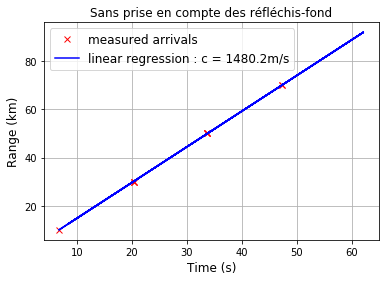

In [201]:
plt.figure()
plt.plot(Tdir, REAL_RANGEdir/1000., 'xr', label = 'measured arrivals')
plt.plot(TT, Rreg1/1000., 'b', label = 'linear regression : c = %.1fm/s' %res1[0])
plt.title('Sans prise en compte des réfléchis-fond')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Range (km)', fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('reg_lin2_gs1', dpi = 100)

## Avec plus de vignettes

In [26]:
### Creat .env file

issp=0                          # sound speed profile number
g1.params['file_type'] = 'A'
g1.params['ALimites'] = [-60.0, 60.0]

g1.params['zmin'] = 0.
g1.params['rmin'] = 0.
g1.params['NDepth'] = 11
g1.params['NRange'] = 21
g1.params['NBeams'] = 12000

g1.generate_envfile('gs',Issp=issp, SSP_depth_step=1, file_env = 'gs1_complete.env' )

In [28]:
### read file .arr 
Arr2_gs1, Pos2_gs1 = s.read_arrivals_asc ('files/gs1_complete.arr', Narrmx = 105)

Max.number of arrivals for source index 0 is 104


In [78]:
### Reponses impulsionnelles
D = np.arange(50., 450.+1., 50.)         # tous les 50m
R = np.arange(5., 95.+1., 5.)* 1000.     # tous les 5km
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos2_gs1['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos2_gs1['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  171


In [79]:
# 1er rayon supérieur à 10dB

isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr2_gs1['Narr'][irr,ird,isd])
        amp = Arr2_gs1['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr2_gs1['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        if len(t_ok) != 0 : 
            t_first = np.min(t_ok)
        
            idx_first = np.where(times==t_first)[0][0]
        
            # Chosen ray features
            NumTopBnc_f = Arr2_gs1['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
            NumBotBnc_f = Arr2_gs1['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
            SrcAngle_f  = Arr2_gs1['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
            # Appends
            TopBnc.append(NumTopBnc_f)
            BotBnc.append(NumBotBnc_f)
            SrcAngle.append(SrcAngle_f)
            Tarr.append(t_first)
            
        else : 
            TopBnc.append(np.NaN)
            BotBnc.append(np.NaN)
            SrcAngle.append(np.NaN)
            Tarr.append(np.NaN)

In [80]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d. ' %(k, len(BotBnc)))
print ('    Ce qui représente %.1f' %( k/len(BotBnc)*100.) + '% des rayons.')

Nombre de réfélchis fond : 90/171. 
    Ce qui représente 52.6% des rayons.


In [81]:
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [82]:
Time = np.array(Tarr)

Rtot = res[0]* Time + res[1]
Diff_tot = REAL_RANGE - Rtot

In [83]:
np.max(abs(Diff_tot))

1824.545355137523

In [84]:
e_t = np.sqrt( np.mean( (Diff_tot)**2 ) )
e_t

802.8072335201477

In [85]:
Rtot1 = res1[0]* Time + res1[1]
Diff_tot1 = REAL_RANGE - Rtot1

In [96]:
np.min(abs(Diff_tot1))

1.1121366087172646

In [87]:
e_t = np.sqrt( np.mean( (Diff_tot1)**2 ) )
e_t

1010.4505579718008

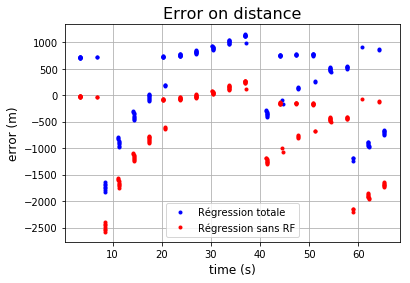

In [107]:
### error on range : real range - range from linear regression
plt.figure()
#plt.plot(Time, Diff3_tot, 'b.', label='Régression Divisée en 3 blocs')
plt.plot(Time, Diff_tot, 'b.', label='Régression totale')

plt.plot(Time, Diff_tot1, 'r.', label='Régression sans RF')

plt.title('Error on distance',fontsize=16)
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('error (m)',fontsize=12)
plt.grid()
plt.legend()

plt.savefig('erreur_gs1_2', dpi=100)

---
---
# Profil Gulf Stream n°2

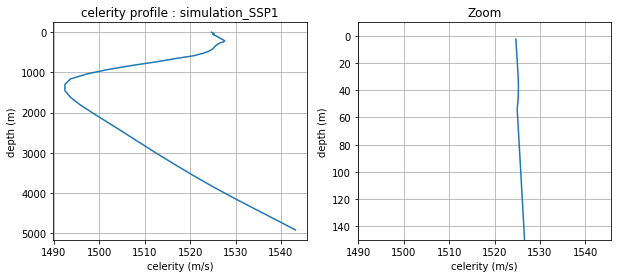

In [88]:
issp=0
g2.plotssp('gs', Issp = issp)
plt.savefig('profile_gs2', dpi=100)

In [168]:
### Creat .env file

issp=0                          # sound speed profile number
g2.params['file_type'] = 'A'
g2.params['ALimites'] = [-60.0, 60.0]

g2.params['zmin'] = 0.
g2.params['rmin'] = 0.
g2.params['NDepth'] = 6
g2.params['NRange'] = 11
g2.params['NBeams'] = 12000

g2.generate_envfile('gs',Issp=issp, SSP_depth_step=1, file_env = 'gs2.env' )

In [89]:
### read file .arr 
Arr_gs2, Pos_gs2 = s.read_arrivals_asc ('files/gs2.arr', Narrmx = 58)

Max.number of arrivals for source index 0 is 57


In [90]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_gs2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_gs2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


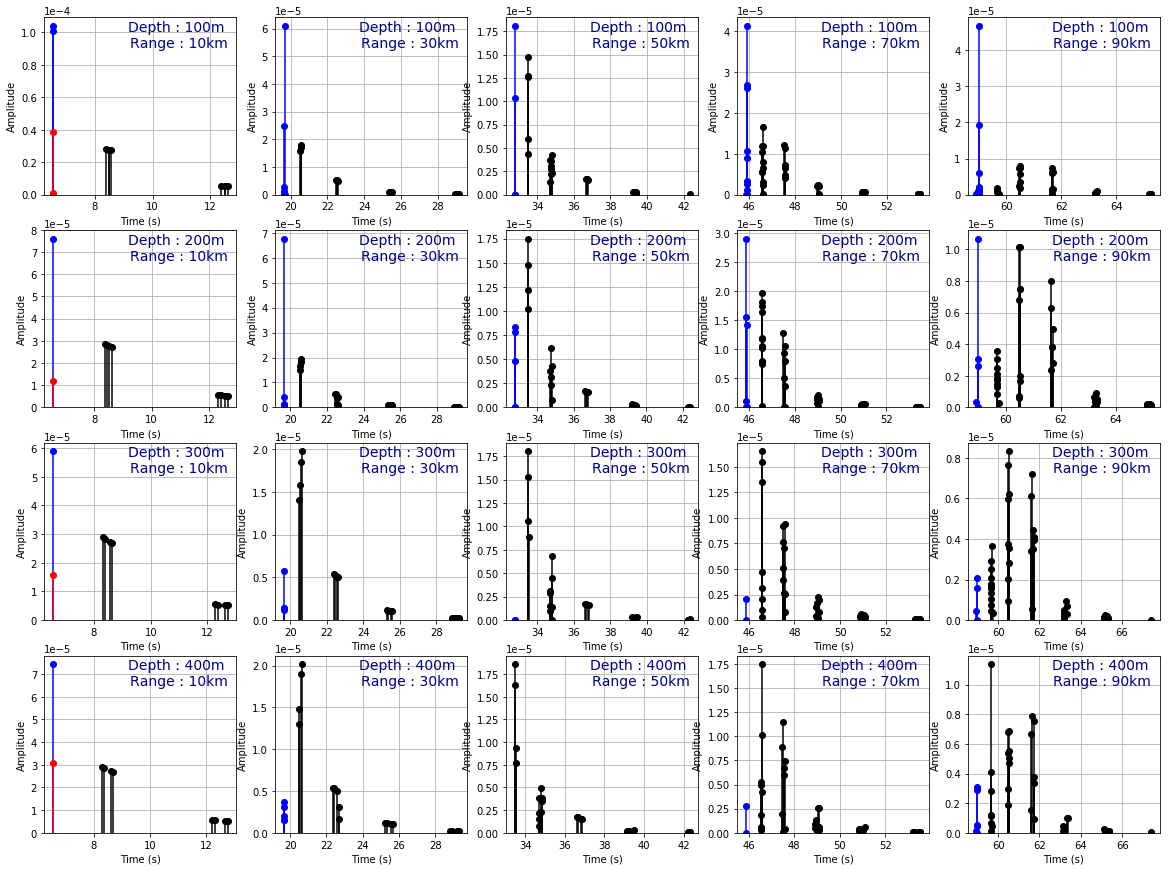

In [91]:
isd = 0       # choice of source depth

Total_time = []
Amp_min = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        s.plotarr(Arr_gs2, Pos_gs2, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr_gs2['Narr'][irr,ird,isd])
        amp = Arr_gs2['A'][irr,:Narr, ird, isd]
        Amp_min.append(np.min(abs(amp)))
        times = Arr_gs2['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))

plt.savefig('vignettes_gs2', dpi=100)

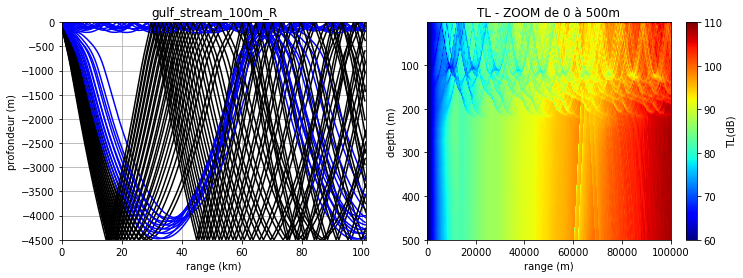

In [93]:
#g2.plot_all(file_ray = '../Partie1_Profondeur_source/files/gulf_stream_100m_R.ray', \
#           file_shd = '../Partie1_Profondeur_source/files/gulf_stream_100m_IB.shd')

g2.plot_all(file_ray = 'gulf_stream_100m_R.ray', \
            file_shd = 'gulf_stream_100m_IB.shd')
plt.savefig('rayons_gs2', dpi=100)

### Zoom

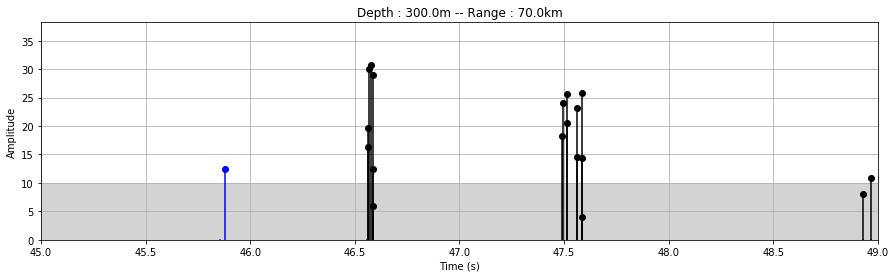

In [177]:
ird = 3       # depth : 300m    
irr = 7       # range : 50km  

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
Narr = int(Arr_gs2['Narr'][irr, ird, isd])
for i in range (Narr) : 
    t = Arr_gs2['delay'][irr, i, ird, isd]
    TL = -20*np.log10 (abs(Arr_gs2['A'][irr, i, ird, isd]))
    RL = SL - TL -NL +DI + PG
    markerline, stemlines, baseline = plt.stem( [t], [RL])            

    if np.logical_and ( Arr_gs2['NumTopBnc'][irr, i,ird,isd] == 0, Arr_gs2['NumBotBnc'][irr, i,ird,isd] == 0):
        plt.setp(stemlines, color = 'r')
        plt.setp(markerline, color = 'r')

    elif Arr_gs2['NumBotBnc'][irr, i,ird,isd] == 0:
        plt.setp(stemlines, color = 'b')
        plt.setp(markerline, color = 'b')

    else : 
        plt.setp(stemlines, color = 'k')
        plt.setp(markerline, color = 'k')

plt.ylim(ymin=0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Source depth : %.1fm -- Receiver depth : %.1fm -- Receiver range : %.1fkm' \
#          % (Pos['s']['depth'][isd], Pos['r']['depth'][ird], Pos['r']['range'][irr]/1000.))
plt.title('Depth : %.1fm -- Range : %.1fkm' %(Pos_gs1['r']['depth'][ird], Pos_gs1['r']['range'][irr]/1000.))
plt.grid()
#plt.xlim([6., 7.5])
#plt.xlim([19.7,20.])
#plt.xlim([33., 33.9])
plt.xlim([45.,49])
#plt.xlim([59.4,59.6])

ax.fill_between(np.array([0.,75.]), np.array([10., 10.]), facecolor='lightgrey')

In [ ]:
### Dans ce cas, une détection sur le 1er rayon (>10dB) semble possible et on peut 
#   essayer de travailler avec une régression linéaire. 

In [166]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_gs2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_gs2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


In [167]:
isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr_gs2['Narr'][irr,ird,isd])
        amp = Arr_gs2['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr_gs2['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        t_first = np.min(t_ok)
        idx_first = np.where(times==t_first)[0][0]

        
        # Chosen ray features
        NumTopBnc_f = Arr_gs2['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
        NumBotBnc_f = Arr_gs2['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
        SrcAngle_f  = Arr_gs2['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
        # Appends
        TopBnc.append(NumTopBnc_f)
        BotBnc.append(NumBotBnc_f)
        SrcAngle.append(SrcAngle_f)
        Tarr.append(t_first)

In [168]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d.' %(k, len(BotBnc)))

Nombre de réfélchis fond : 2/20.


In [169]:
n = R.size
print('Nombre de réfléxions sur la surface : \n')
print ('                 10km     30km     50km      70km     90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d        %d        %d        %d        %d' %(D[i], TopBnc[n*i], \
                                                                TopBnc[n*i+1], TopBnc[n*i+2], \
                                                                TopBnc[n*i+3], TopBnc[n*i+4]))

Nombre de réfléxions sur la surface : 

                 10km     30km     50km      70km     90km

  Depth = 100m :   0        2        3        5        8
  Depth = 200m :   0        2        4        5        6
  Depth = 300m :   0        2        0        5        6
  Depth = 400m :   0        1        0        5        6


In [170]:
### On connaît le temps d'arrivée et le range correspondant pour les 20 vignettes
TT = np.array(Tarr)
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [171]:
### regression linéaire 
### 1 régression linéaire
res = np.polyfit(TT[~np.isnan(TT)], REAL_RANGE[~np.isnan(TT)],1)
Rreg = res[0] * TT + res[1]
Diff = REAL_RANGE - Rreg


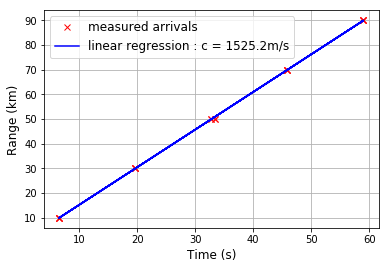

In [172]:
plt.figure()
plt.plot(TT, REAL_RANGE/1000., 'xr', label = 'measured arrivals')
plt.plot(TT, Rreg/1000., 'b', label = 'linear regression : c = %.1fm/s' %res[0])
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Range (km)', fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('reg_lin1_gs2', dpi = 100)

In [173]:
# régression linéaire avec les non-reflechis fond seulement

BotBnc
idx_dir = [] 
for i in range(len(BotBnc)):
    if BotBnc[i] == 0. :
        idx_dir.append(i)
        
Tdir = TT[idx_dir]
REAL_RANGEdir = REAL_RANGE[idx_dir]

res1 = np.polyfit(Tdir, REAL_RANGEdir,1)
Rreg1 = res1[0] * TT + res1[1]
Diff1 = REAL_RANGE - Rreg1

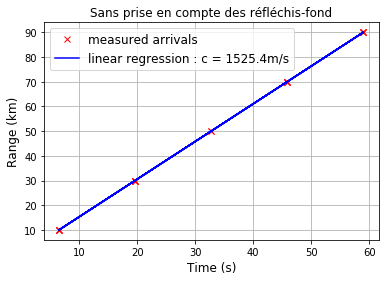

In [175]:
plt.figure()
plt.plot(Tdir, REAL_RANGEdir/1000., 'xr', label = 'measured arrivals')
plt.plot(TT, Rreg1/1000., 'b', label = 'linear regression : c = %.1fm/s' %res1[0])
plt.title('Sans prise en compte des réfléchis-fond')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Range (km)', fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('reg_lin2_gs2', dpi = 100)

### Avec plus de vignettes

In [121]:
### Creat .env file

issp=0                          # sound speed profile number
g2.params['file_type'] = 'A'
g2.params['ALimites'] = [-60.0, 60.0]

g2.params['zmin'] = 0.
g2.params['rmin'] = 0.
g2.params['NDepth'] = 11
g2.params['NRange'] = 21
g2.params['NBeams'] = 12000

g2.generate_envfile('gs',Issp=issp, SSP_depth_step=1, file_env = 'gs2_complete.env' )

In [123]:
### read file .arr 
Arr2_gs2, Pos2_gs2 = s.read_arrivals_asc ('files/gs2_complete.arr', Narrmx = 80)

Max.number of arrivals for source index 0 is 79


In [176]:
### Reponses impulsionnelles
D = np.arange(50., 450.+1., 50.)         # tous les 50m
R = np.arange(5., 95.+1., 5.)* 1000.     # tous les 5km
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos2_gs2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos2_gs2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  171


In [177]:
# 1er rayon supérieur à 10dB

isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr2_gs2['Narr'][irr,ird,isd])
        amp = Arr2_gs2['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr2_gs2['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        if len(t_ok) != 0 : 
            t_first = np.min(t_ok)
        
            idx_first = np.where(times==t_first)[0][0]
        
            # Chosen ray features
            NumTopBnc_f = Arr2_gs2['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
            NumBotBnc_f = Arr2_gs2['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
            SrcAngle_f  = Arr2_gs2['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
            # Appends
            TopBnc.append(NumTopBnc_f)
            BotBnc.append(NumBotBnc_f)
            SrcAngle.append(SrcAngle_f)
            Tarr.append(t_first)
            
        else : 
            TopBnc.append(np.NaN)
            BotBnc.append(np.NaN)
            SrcAngle.append(np.NaN)
            Tarr.append(np.NaN)

In [178]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d. ' %(k, len(BotBnc)))
print ('    Ce qui représente %.1f' %( k/len(BotBnc)*100.) + '% des rayons.')

Nombre de réfélchis fond : 45/171. 
    Ce qui représente 26.3% des rayons.


In [179]:
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [180]:
Time = np.array(Tarr)

Rtot = res[0]* Time + res[1]
Diff_tot = REAL_RANGE - Rtot

In [181]:
np.max(abs(Diff_tot))

2097.8277799278585

In [182]:
e_t = np.sqrt( np.mean( (Diff_tot)**2 ) )
e_t

561.1565879766054

In [183]:
Rtot1 = res1[0]* Time + res1[1]
Diff_tot1 = REAL_RANGE - Rtot1

In [188]:
np.min(abs(Diff_tot1))

0.10509133379673585

In [185]:
e_t = np.sqrt( np.mean( (Diff_tot1)**2 ) )
e_t

608.2293530066373

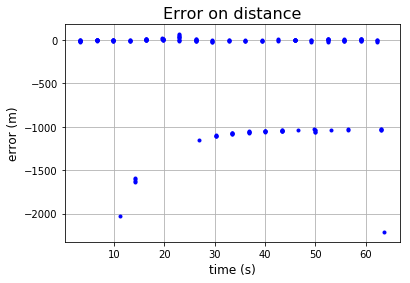

In [186]:
### error on range : real range - range from linear regression
plt.figure()
#plt.plot(Time, Diff3_tot, 'b.', label='Régression Divisée en 3 blocs')
#plt.plot(Time, Diff_tot, 'b.', label='Régression unique')

plt.plot(Time, Diff_tot1,'b.', label='Régression sans RF')

plt.title('Error on distance',fontsize=16)
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('error (m)',fontsize=12)
plt.grid()
#plt.legend(loc=4)

plt.savefig('erreur_gs2', dpi=100)

In [161]:
# régression linéaire avec les non-reflechis fond seulement

BotBnc
idx_dir = [] 
for i in range(len(BotBnc)):
    if BotBnc[i] == 0. :
        idx_dir.append(i)
        
Tdir = Time[idx_dir]
REAL_RANGEdir = REAL_RANGE[idx_dir]


In [162]:
Rtot1dir = res1[0]* Tdir + res1[1]
Diff_tot1dir = REAL_RANGEdir - Rtot1dir

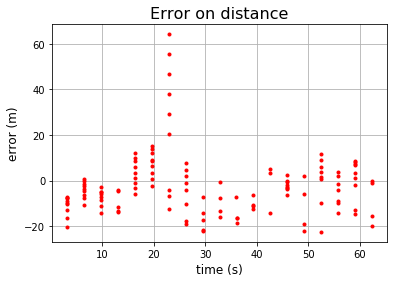

In [163]:
### error on range : real range - range from linear regression
plt.figure()
#plt.plot(Time, Diff3_tot, 'b.', label='Régression Divisée en 3 blocs')
#plt.plot(Time, Diff_tot, 'b.', label='Régression unique')

plt.plot(Tdir, Diff_tot1dir,'r.', label='Régression sans RF')

plt.title('Error on distance',fontsize=16)
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('error (m)',fontsize=12)
plt.grid()
#plt.legend(loc=4)

plt.savefig('erreur_gs2', dpi=100)

In [164]:
e_t = np.sqrt( np.mean( (Diff_tot1dir)**2 ) )
e_t

13.833377519856192

In [189]:
np.min(abs(Diff_tot1dir))

0.10509133379673585

---
----
---

## Idées ...

In [ ]:
# écrire les .env
# executer bellhop
# lire les .arr et tracer les 20 (ou plus) vignettes

# trouver la tendance
# définir des zones
# faire des stats 


# trajectoire effectuée par le rayon (lancer eigenrays E, puis calcul de la distance)
# quelle erreur si trajectoire approximée à une trajectoire directe par exemple ? 

In [ ]:
## conclusion : y a-t-il des méthodes de détection privilégiées ? 

In [ ]:
# Quelle erreur si mauvaise détection ? 
# Quelle conséquence si paquet et pas rayon isolé ? 
# 